# [Collision Avoidance Challenge](https://kelvins.esa.int/collision-avoidance-challenge/home/)
## Introduction
Today, active **collision avoidance** among orbiting satellites has become a routine task in space operations, relying on validated, accurate and timely space surveillance data. For a typical satellite in Low Earth Orbit, hundreds of alerts are issued every week corresponding to possible close encounters between a satellite and another space object (in the form of conjunction data messages CDMs). After automatic processing and filtering, there remain about 2 actionable alerts per spacecraft and week, requiring detailed follow-up by an analyst. On average, at the European Space Agency, more than one collision avoidance manoeuvre is performed per satellite and year.


In this challenge, you are tasked to build a model to predict the final collision risk estimate between a given satellite and a space object (e.g. another satellite, space debris, etc). To do so, you will have access to a database of real-world conjunction data messages (CDMs) carefully prepared at ESA. Learn more about the challenge and the data.

This competition is organized by ESA's Advanced Concepts Team (ACT) in partnership with ESA's Space Debris Office

Experts from both teams are available for interactions during the competition.

## Challenge

As of estimations done in January 2019, more than 34,000 objects with a size larger than 10cm are orbiting our planet. Of these, 22,300 are tracked by the Space Surveillance Network and their position released in the form of a globally shared catalogue.


ESA's Space Debris Office supports collision avoidance activities covering the ESA missions Aeolus, Cryosat-2 and the constellation of Swarm-A/B/C in low-Earth orbit and Cluster-II in highly eccentric orbit approaching the Geostationary (GEO) region. On top of these, more than a dozen spacecraft of partner agencies and commercial operators are supported.

![Alt text](https://kelvins.esa.int/media/public/ckeditor_uploads/2021/08/05/new_swarm.png "Title")

In the context of this activity, the orbits of these satellites are propagated and when a close approach with any object in the catalogue is detected a **Conjunction Data Message** (CDM) is assembled and released. Each CDM **contains multiple attributes** about the approach, such as the identity of the satellite in question, the object type of the potential collider, the time of closest approach (TCA), the uncertainty (i.e. covariances), etc. It also contains a **self-reported** risk, which is computed using some of the attributes from the CDM. In the days following the first CDM, as the uncertainties of the objects positions become smaller, other CDMs are released refining the knowledge acquired on the close encounter.

Typically, a **time series** of CDMs covering one week is released **for each unique close approach**, with about 3 CDMs becoming available per day. For a given close approach the last obtained CDM, including the computed risk, can be assumed to be the **best knowledge** we have about the potential collision and the state of the two objects in question. In most cases, the Space Debris Office will alarm control teams and start thinking about a potential avoidance manoeuvre 2 days prior to the close approach in order to avoid the risk of collision, to then make a final decision 1 day prior. In this challenge, we ask to **build a model** that makes use of the CDMs recorded up to 2 days prior to the closest approach to **predict the final risk** (i.e. the risk predicted in the last available CDM prior to close approach).

More about the dataset used in this competition and the attributes contained in the various CDMs can be found in the data section. You can also learn some more about the current way ESA's Space Debris office deals with collision avoidance manoeuvres reading this [paper](https://kelvins.esa.int/media/public/competitions/collision-avoidance-challenge/SDC7-paper1017.pdf).

We thank the US Space Surveillance Network for the provision of surveillance data supporting safe operations of ESA’s spacecraft. Specifically, we are grateful to the agreement which allows to publicly release the dataset for the purpose of this competition.

## Data

### Differences Between Training and Testing Data
Each dataset is made of several unique events (close encounters betwen two objects) which are indexed by a unique number in the `event_i` column.

- The `training` set has 162634 rows and **13154 unique events** (giving on average about 12 rows/CDMs per close encounter).

- The `testing` set has 24484 rows and **2167 unique events** (giving on average about 11 rows/CDMs per close encounter).

**Important: Note that the `testing` set and the `training` set have not been randomly sampled from the database. In other words, while they come from the same database, with the same collection process and the same features, they have been hand picked in order to over-represent high risk events and to create an interesting predictive model. This is a characterstic of this competition where high risk events are scarce, but represent the true final target of a useful predictive model.**

In particular, the `testing` data differs in two major ways compared to the `training` set:

 * It only contains events for which the latest CDM is within 1 day ( `time_to_tc` < 1) of the time to closest approach (TCA). This is because, in some cases, the latest available CDM is days away from the (known) time to closest approach. It would be wrong to assume that the computed risk 7 days before the actual time to closest approach can be a good approximation to the risk at TCA. Furthermore, predicting the risk many days prior the time to closest approach is not of great interest to us. On the other hand, the `training` set is unfiltered and you will find many cases where the latest available CDMs is days away from the TCA. We have chosen to keep these collision events in the training set because they may still be useful when it comes to predicting events from the test set.

 * There are no CDMs to learn from which are within 2 days of the TCA. In other words, the data available closest to the TCA will be at least 2 days away. This is because, as mentioned in the challenge section, a potential avoidance manoeuvre is planned at least 2 days prior to closest approach. Similarly to the above, the `training` set will contain all cases, including events where no data is available at least 2 days prior to closest approach (i.e. events with all their CDMs being within 2 days of TCA are still present in the dataset).
 
### Columns Description

The dataset is represented as a table, where each row correspond to a single CDM, and each CDM contains 103 recorded characteristics/features. There are thus 103 columns, which we describe below. The dataset is made of several unique collision/close approach events, which are identified in the `event_id` column. In turn, each collision event is made of several CDMs recorded over time. Therefore, a single collision event can be thought of as a times series of CDMs. From these CDMs, for every collision event, we are interested in predicting the final risk which is computed in the last CDM of the time series (i.e. the risk value in the last row of each collision event).

For the column description, we first describe columns which have unique names and then the columns whose name difference only depends on whether they are referring to the target object (if the column name starts with a **t**) or the chaser object (if the column name starts with a **c**). Here, target refers to the ESA satellites while chaser refers to the space debris/object we want to avoid. describe the column names shared for both the chaser and the target, we replace **t** and **c** with the placeholder **x**. For instance, `c_sigma_r` and `t_sigma_r` both correspond to the description of `x_sigma_r`.

Note that all the columns are numerical except for `c_object_type`.

#### Uniquely Named Columns

| Column      | Description |
| :---------: | :---------- |
| `risk`|self-computed value at the epoch of each CDM [base 10 log]. **In the test set, this value is to be predicted, at the time of closest approach for each `event_id`. Note that, as mentioned above, in the `test` set, we do not know the actual data contained in CDMs that are within 2 days to closest approach, since they happen in the "future".**|
| `event_id`| Unique id per collision event|
| `time_to_tca`| Time interval between CDM creation and time-of-closest approach [days]|
| `mission_id`| Identifier of mission that will be affected|
| `max_risk_estimate`| Maximum collision probability obtained by scaling combined covariance|
| `max_risk_scaling`| Scaling factor used to compute maximum collision probability|
| `miss_distance`| Relative position between chaser & target at tca [m]|
| `relative_speed`| Relative speed between chaser & target at tca [m/s]|
| `relative_position_n`| Relative position between chaser & target: normal (cross-track) [m]|
| `relative_position_r`| Relative position between chaser & target: radial [m]|
| `relative_position_t`| Relative position between chaser & target: transverse (along-track) [m]|
| `relative_velocity_n`| Relative velocity between chaser & target: normal (cross-track) [m/s]|
| `relative_velocity_r`| Relative velocity between chaser & target: radial [m/s]|
| `relative_velocity_t`| Relative velocity between chaser & target: transverse (along-track) [m/s]|
| `c_object_type`| Object type which is at collision risk with satellite|
| `geocentric_latitude`| Latitude of conjunction point [deg]|
| `azimuth`| Relative velocity vector: azimuth angle [deg]|
| `elevation`| Relative velocity vector: elevation angle [deg]|
| `F10`| 10.7 cm radio flux index [10−2210−22 W/(m2m2 Hz)]|
| `AP`| Daily planetary geomagnetic amplitude index|
| `F3M`| 81-day running mean of F10.7 (over 3 solar rotations) [10−2210−22 W/(m2m2 Hz)]|
| `SSN`| Wolf sunspot number|

#### Shared Column Names Between the Chaser and the Target Object
| Column      | Description |
| :---------: | :---------- |
 | `x_sigma_rdot`| Covariance; radial velocity standard deviation (sigma) [m/s]
 | `x_sigma_n`| Covariance; (cross-track) position standard deviation (sigma) [m]
 | `x_cn_r`| Covariance; correlation of normal (cross-track) position vs radial position
 | `x_cn_t`| Covariance; correlation of normal (cross-track) position vs transverse (along-track) position
 | `x_cndot_n`| Covariance; correlation of normal (cross-track) velocity vs normal (cross-track) position
 | `x_sigma_ndot`| Covariance; normal (cross-track) velocity standard deviation (sigma) [m/s]
 | `x_cndot_r`| Covariance; correlation of normal (cross-track) velocity vs radial position
 | `x_cndot_rdot`| Covariance; correlation of normal (cross-track) velocity vs radial velocity
 | `x_cndot_t`| Covariance; correlation of normal (cross-track) velocity vs transverse (along-track) position
 | `x_cndot_tdot`| Covariance; correlation of normal (cross-track) velocity vs transverse (along-track) velocity
 | `x_sigma_r`| Covariance; radial position standard deviation (sigma) [m]
 | `x_ct_r`| Covariance; correlation of transverse (along-track) position vs radial position
 | `x_sigma_t`| Covariance; transverse (along-track) position standard deviation (sigma) [m]
 | `x_ctdot_n`| Covariance; correlation of transverse (along-track) velocity vs normal (cross-track) position
 | `x_crdot_n`| Covariance; correlation of radial velocity vs normal (cross-track) position
 | `x_crdot_t`| Covariance; correlation of radial velocity vs transverse (along-track) position
 | `x_crdot_r`| Covariance; correlation of radial velocity vs radial position
 | `x_ctdot_r`| Covariance; correlation of transverse (along-track) velocity vs radial position
 | `x_ctdot_rdot`| Covariance; correlation of transverse (along-track) velocity vs radial velocity
 | `x_ctdot_t`| Covariance; correlation of transverse (along-track) velocity vs transverse (along-track) position
 | `x_sigma_tdot`| Covariance; transverse (along-track) velocity standard deviation (sigma) [m/s]
 | `x_position_covariance_det`| Determinant of covariance (~volume)
 | `x_cd_area_over_mass`| Ballistic coefficient [m2m2/kg]
| `x_cr_area_over_mass`| Solar radiation coefficient . A/m (ballistic coefficient equivalent)
 | `x_h_apo`| Apogee (-RearthRearth) [km]
 | `x_h_per`| Perigee (-RearthRearth)[km]
 | `x_j2k_ecc`| Eccentricity
 | `x_j2k_inc`| Inclination [deg]
 | `x_j2k_sma`| Semi-major axis [km]
 | `x_sedr`| Energy dissipation rate [W/kg]
 | `x_span`| Size used by the collision risk computation algorithm (minimum 2 m diameter assumed for the chaser) [m]
 | `x_rcs_estimate`| Radar cross-sectional area [m2m2]
 | `x_actual_od_span`| Actual length of update interval for orbit determination [days]
 | `x_obs_available`| Number of observations available for orbit determination (per CDM)
 | `x_obs_used`| Number of observations used for orbit determination (per CDM)
 | `x_recommended_od_span`| Recommended length of update interval for orbit determination [days]
 | `x_residuals_accepted`| Orbit determination residuals
 | `x_time_lastob_end`| End of the time interval in days (with respect to the CDM creation epoch) of the last accepted observation used in the orbit determination
 | `x_time_lastob_start`| Start of the time in days (with respect to the CDM creation epoch) of the last accepted observation used in the orbit determination
 | `x_weighted_rms`| Root-mean-square in least-squares orbit determination

# Exploratory Data Analysis (EDA)

The development of any Machine Learning model requires a solid knowledge of the data available for its training and subsequent development in order to guarantee a successful deployment and applicability to real-world problems. For this purpose, in this section we develop a comprehensive *Exploratory Data Analysis* (EDA) on the Kelvins Collision Avoidance Challenge `training` and `test` datasets with two main objectives in mind:
 - Acquire a solid understanding of real data received in a conventional Conjunction Data Message (CDM); this involves a basic analysis of the data distribution and its potential common patterns for ***Target*** and ***Chaser*** objects, and cluster identification for conjunction events.
 
- Develop a Synthetic Data Generation (SDG) process that can reliably produce additional virtual (non-existing) data with the objective to enrich the Time-Series Forecasting Deep Learning model and improve its performance in production by reinforcing its training process.

For this purpose, this notebook is structured in the following sections:

1. Data import and initial exploration.
2. Data distribution analysis.
3. Synthetic data generation using estimated Probability Densities computed with Parametric and Non-Parametric approaches.
4. Virtual Conjunction Data Message (CDM) creation



## Import required libraries
All the relevant libraries required to perform the EDA, SDG, and CDM creation in this notebook are imported in the code block below:

In [1]:
# Import custom libraries from local folder.
import sys
sys.path.append("..")

# Import libraries required for EDA
import pandas as pd
import numpy as np
import os
import warnings
from importlib import reload

from matplotlib import pyplot as plt, rc

# Import json library and create function to format dictionaries.
import json
format_json = lambda x: json.dumps(x, indent=4)

# Import pandas and set pandas DataFrame visualization parameters
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    

# Import local modules
import scalib.utils as utils
import scalib.eda as eda
import scalib.cfg as cfg

# Get current working directory path for the tool parent folder and print it.
print('Parent working directory: %s' % utils.cwd)

Parent working directory: /Users/jjrr/Documents/SCA-Project/scalib


## 1. - Import Collision Avoidance Challenge dataset

As an example, we first show the case in which the data comes from the Kelvins competition. For this, we built a specific converter that takes care of the conversion from Kelvins format to standard CDM format (the data can be downloaded at [kelvins.esa.int](https://kelvins.esa.int/collision-avoidance-challenge/data/):

In [2]:
# Import library to import Kelvins challlenge data
from scalib.eda import kelvins_challenge_events

# Import Kelvins dataset and convert it to dataframes in CCSDS format
for filename in ['test_data.csv', 'train_data.csv']:

    filepath_dest = os.path.join(utils.cwd,'data','ccsds', filename)
    filepath_orig = os.path.join(utils.cwd,'data','esa-challenge', filename)

    if os.path.exists(filepath_dest):
        df = pd.read_csv(filepath_dest, index_col=0)
    else:

        # Get ConjunctionEventsDataset object 
        events = kelvins_challenge_events(filepath_orig,
                    drop_features = ['c_rcs_estimate', 't_rcs_estimate'])

        # Convert Conjunction Events Dataset to pandas DataFrame and save it.
        df = events.to_dataframe(event_id=True)
        df.to_csv(filepath_dest)
        
display(df.head(10))

# Get only last CDM data from every event_id
df_firstCDM = df.drop_duplicates('__EVENT_ID', keep='first')
df_lastCDM  = df.drop_duplicates('__EVENT_ID', keep='last')

,CCSDS_CDM_VERS,CREATION_DATE,ORIGINATOR,MESSAGE_FOR,MESSAGE_ID,TCA,MISS_DISTANCE,RELATIVE_SPEED,RELATIVE_POSITION_R,RELATIVE_POSITION_T,RELATIVE_POSITION_N,RELATIVE_VELOCITY_R,RELATIVE_VELOCITY_T,RELATIVE_VELOCITY_N,START_SCREEN_PERIOD,STOP_SCREEN_PERIOD,SCREEN_VOLUME_FRAME,SCREEN_VOLUME_SHAPE,SCREEN_VOLUME_X,SCREEN_VOLUME_Y,SCREEN_VOLUME_Z,SCREEN_ENTRY_TIME,SCREEN_EXIT_TIME,COLLISION_PROBABILITY,COLLISION_PROBABILITY_METHOD,OBJECT1_OBJECT,OBJECT1_OBJECT_DESIGNATOR,OBJECT1_CATALOG_NAME,OBJECT1_OBJECT_NAME,OBJECT1_INTERNATIONAL_DESIGNATOR,OBJECT1_OBJECT_TYPE,OBJECT1_OPERATOR_CONTACT_POSITION,OBJECT1_OPERATOR_ORGANIZATION,OBJECT1_OPERATOR_PHONE,OBJECT1_OPERATOR_EMAIL,OBJECT1_EPHEMERIS_NAME,OBJECT1_COVARIANCE_METHOD,OBJECT1_MANEUVERABLE,OBJECT1_ORBIT_CENTER,OBJECT1_REF_FRAME,OBJECT1_GRAVITY_MODEL,OBJECT1_ATMOSPHERIC_MODEL,OBJECT1_N_BODY_PERTURBATIONS,OBJECT1_SOLAR_RAD_PRESSURE,OBJECT1_EARTH_TIDES,OBJECT1_INTRACK_THRUST,OBJECT1_TIME_LASTOB_START,OBJECT1_TIME_LASTOB_END,OBJECT1_RECOMMENDED_OD_SPAN,OBJECT1_ACTUAL_OD_SPAN,OBJECT1_OBS_AVAILABLE,OBJECT1_OBS_USED,OBJECT1_TRACKS_AVAILABLE,OBJECT1_TRACKS_USED,OBJECT1_RESIDUALS_ACCEPTED,OBJECT1_WEIGHTED_RMS,OBJECT1_AREA_PC,OBJECT1_AREA_DRG,OBJECT1_AREA_SRP,OBJECT1_MASS,OBJECT1_CD_AREA_OVER_MASS,OBJECT1_CR_AREA_OVER_MASS,OBJECT1_THRUST_ACCELERATION,OBJECT1_SEDR,OBJECT1_X,OBJECT1_Y,OBJECT1_Z,OBJECT1_X_DOT,OBJECT1_Y_DOT,OBJECT1_Z_DOT,OBJECT1_CR_R,OBJECT1_CT_R,OBJECT1_CT_T,OBJECT1_CN_R,OBJECT1_CN_T,OBJECT1_CN_N,OBJECT1_CRDOT_R,OBJECT1_CRDOT_T,OBJECT1_CRDOT_N,OBJECT1_CRDOT_RDOT,OBJECT1_CTDOT_R,OBJECT1_CTDOT_T,OBJECT1_CTDOT_N,OBJECT1_CTDOT_RDOT,OBJECT1_CTDOT_TDOT,OBJECT1_CNDOT_R,OBJECT1_CNDOT_T,OBJECT1_CNDOT_N,OBJECT1_CNDOT_RDOT,OBJECT1_CNDOT_TDOT,OBJECT1_CNDOT_NDOT,OBJECT1_CDRG_R,OBJECT1_CDRG_T,OBJECT1_CDRG_N,OBJECT1_CDRG_RDOT,OBJECT1_CDRG_TDOT,OBJECT1_CDRG_NDOT,OBJECT1_CDRG_DRG,OBJECT1_CSRP_R,OBJECT1_CSRP_T,OBJECT1_CSRP_N,OBJECT1_CSRP_RDOT,OBJECT1_CSRP_TDOT,OBJECT1_CSRP_NDOT,OBJECT1_CSRP_DRG,OBJECT1_CSRP_SRP,OBJECT1_CTHR_R,OBJECT1_CTHR_T,OBJECT1_CTHR_N,OBJECT1_CTHR_RDOT,OBJECT1_CTHR_TDOT,OBJECT1_CTHR_NDOT,OBJECT1_CTHR_DRG,OBJECT1_CTHR_SRP,OBJECT1_CTHR_THR,OBJECT2_OBJECT,OBJECT2_OBJECT_DESIGNATOR,OBJECT2_CATALOG_NAME,OBJECT2_OBJECT_NAME,OBJECT2_INTERNATIONAL_DESIGNATOR,OBJECT2_OBJECT_TYPE,OBJECT2_OPERATOR_CONTACT_POSITION,OBJECT2_OPERATOR_ORGANIZATION,OBJECT2_OPERATOR_PHONE,OBJECT2_OPERATOR_EMAIL,OBJECT2_EPHEMERIS_NAME,OBJECT2_COVARIANCE_METHOD,OBJECT2_MANEUVERABLE,OBJECT2_ORBIT_CENTER,OBJECT2_REF_FRAME,OBJECT2_GRAVITY_MODEL,OBJECT2_ATMOSPHERIC_MODEL,OBJECT2_N_BODY_PERTURBATIONS,OBJECT2_SOLAR_RAD_PRESSURE,OBJECT2_EARTH_TIDES,OBJECT2_INTRACK_THRUST,OBJECT2_TIME_LASTOB_START,OBJECT2_TIME_LASTOB_END,OBJECT2_RECOMMENDED_OD_SPAN,OBJECT2_ACTUAL_OD_SPAN,OBJECT2_OBS_AVAILABLE,OBJECT2_OBS_USED,OBJECT2_TRACKS_AVAILABLE,OBJECT2_TRACKS_USED,OBJECT2_RESIDUALS_ACCEPTED,OBJECT2_WEIGHTED_RMS,OBJECT2_AREA_PC,OBJECT2_AREA_DRG,OBJECT2_AREA_SRP,OBJECT2_MASS,OBJECT2_CD_AREA_OVER_MASS,OBJECT2_CR_AREA_OVER_MASS,OBJECT2_THRUST_ACCELERATION,OBJECT2_SEDR,OBJECT2_X,OBJECT2_Y,OBJECT2_Z,OBJECT2_X_DOT,OBJECT2_Y_DOT,OBJECT2_Z_DOT,OBJECT2_CR_R,OBJECT2_CT_R,OBJECT2_CT_T,OBJECT2_CN_R,OBJECT2_CN_T,OBJECT2_CN_N,OBJECT2_CRDOT_R,OBJECT2_CRDOT_T,OBJECT2_CRDOT_N,OBJECT2_CRDOT_RDOT,OBJECT2_CTDOT_R,OBJECT2_CTDOT_T,OBJECT2_CTDOT_N,OBJECT2_CTDOT_RDOT,OBJECT2_CTDOT_TDOT,OBJECT2_CNDOT_R,OBJECT2_CNDOT_T,OBJECT2_CNDOT_N,OBJECT2_CNDOT_RDOT,OBJECT2_CNDOT_TDOT,OBJECT2_CNDOT_NDOT,OBJECT2_CDRG_R,OBJECT2_CDRG_T,OBJECT2_CDRG_N,OBJECT2_CDRG_RDOT,OBJECT2_CDRG_TDOT,OBJECT2_CDRG_NDOT,OBJECT2_CDRG_DRG,OBJECT2_CSRP_R,OBJECT2_CSRP_T,OBJECT2_CSRP_N,OBJECT2_CSRP_RDOT,OBJECT2_CSRP_TDOT,OBJECT2_CSRP_NDOT,OBJECT2_CSRP_DRG,OBJECT2_CSRP_SRP,OBJECT2_CTHR_R,OBJECT2_CTHR_T,OBJECT2_CTHR_N,OBJECT2_CTHR_RDOT,OBJECT2_CTHR_TDOT,OBJECT2_CTHR_NDOT,OBJECT2_CTHR_DRG,OBJECT2_CTHR_SRP,OBJECT2_CTHR_THR,__RISK,__MAX_RISK_ESTIMATE,__MAX_RISK_SCALING,__CREATION_DATE,__TCA,__DAYS_TO_TCA,__EVENT_ID
0,1.0,2023-08-31T20:57:01.182385,NaN,NaN,NaN,2023-09-02T10:33:12.549385,14923.0,137

## 2. - Conjunction Events data distribution analysis


In order to generate synthetic Conjunction Data Messages containing realistic features in line with current ASOs population in the near Earth space environment it is important to analyse not only the features of every conjunction such as the miss distance or the estimated risk but also the features of the Target and Chaser objects orbits and the parameters inherent from their observations.  For this purpose, we consider only the obligatory data provided per CDM:
 * **Relative metadata**: information related to the conjunction itself, including TCA and miss distance. 
 * **Object specific state data**: information about the absolute position and velocity of both objects.
 * **Object specific covariance data**: elements of the covariance matrix for the state vector in the RTN framework.




In [3]:
num_clusters = ['relative_metadata_obligatory',
                'data_state_obligatory',
                'data_covariance_obligatory']
cat_clusters = ['header_obligatory',
                'metadata_obligatory']

obligatory_features = {k:v for k,v in cfg.cdm_clusters_obligatory.items() if v}

print(format_json(obligatory_features))

{
    "header_obligatory": [
        "CCSDS_CDM_VERS",
        "CREATION_DATE",
        "ORIGINATOR",
        "MESSAGE_ID"
    ],
    "relative_metadata_obligatory": [
        "TCA",
        "MISS_DISTANCE"
    ],
    "metadata_obligatory": [
        "OBJECT",
        "OBJECT_DESIGNATOR",
        "CATALOG_NAME",
        "OBJECT_NAME",
        "INTERNATIONAL_DESIGNATOR",
        "EPHEMERIS_NAME",
        "COVARIANCE_METHOD",
        "MANEUVERABLE",
        "REF_FRAME"
    ],
    "data_state_obligatory": [
        "X",
        "Y",
        "Z",
        "X_DOT",
        "Y_DOT",
        "Z_DOT"
    ],
    "data_covariance_obligatory": [
        "CR_R",
        "CT_R",
        "CT_T",
        "CN_R",
        "CN_T",
        "CN_N",
        "CRDOT_R",
        "CRDOT_T",
        "CRDOT_N",
        "CRDOT_RDOT",
        "CTDOT_R",
        "CTDOT_T",
        "CTDOT_N",
        "CTDOT_RDOT",
        "CTDOT_TDOT",
        "CNDOT_R",
        "CNDOT_T",
        "CNDOT_N",
        "CNDOT_RDOT",
   

### 2.1. - Relative metadata
Work in progress (*confidential data*).

### 2.2. - State vector data
Work in progress (*confidential data*).

### 2.3. - Covariance data

The analysis of the covariance matrix in the RTN Coordinate frame of the state vector is key as it is a measure of the error of the orbit prediction. From a mathematical perspective, it is expressed as follows:

$$\newcommand{\cov}{\mathrm{cov}}
\begin{bmatrix}
\sigma^2_{R} & - & - & - & - & - \\
\cov(T,R) & \sigma^2_{T} & - & - & - & - \\
\cov(N,R) & \cov(N,T) & \sigma^2_{N} & - & - & - \\
\cov(\dot{R},R) & \cov(\dot{R},T) & \cov(\dot{R},N) & \sigma^2_{\dot{R}} & - & - \\
\cov(\dot{T},R) & \cov(\dot{T},T) & \cov(\dot{T},N) & \cov(\dot{T},\dot{R}) & \sigma^2_{\dot{T}} & - \\
\cov(\dot{N},R) & \cov(\dot{N},T) & \cov(\dot{N},N) & \cov(\dot{N},\dot{R}) & \cov(\dot{N},\dot{T}) & \sigma^2_{\dot{N}} \\
\end{bmatrix}$$

where the terms above the main diagonal are the same as the one below, that is, is a symmetrical matrix. It takes into account uncertainties inherent from the orbit determination methods used for the creation of the CDM. Therefore, it directly affects the estimated risk of collision and, as a consequence, the DL model to be developed.

For the SCMDG process, the development of a realistic covariance matrix assigned to every CDM is crucial to predict future collisions taking into account limitations of the technology available nowadays. At the same time, the apropriate manipulation of this matrix can help to identify required thresholds for improvement in order to get better predictions of collisions earlier in time.

Since uncertainties need to be replicated in the SCDMG process, a multicollinearity analysis is performed below to avoid trivial data generation, and non-necessary processing:

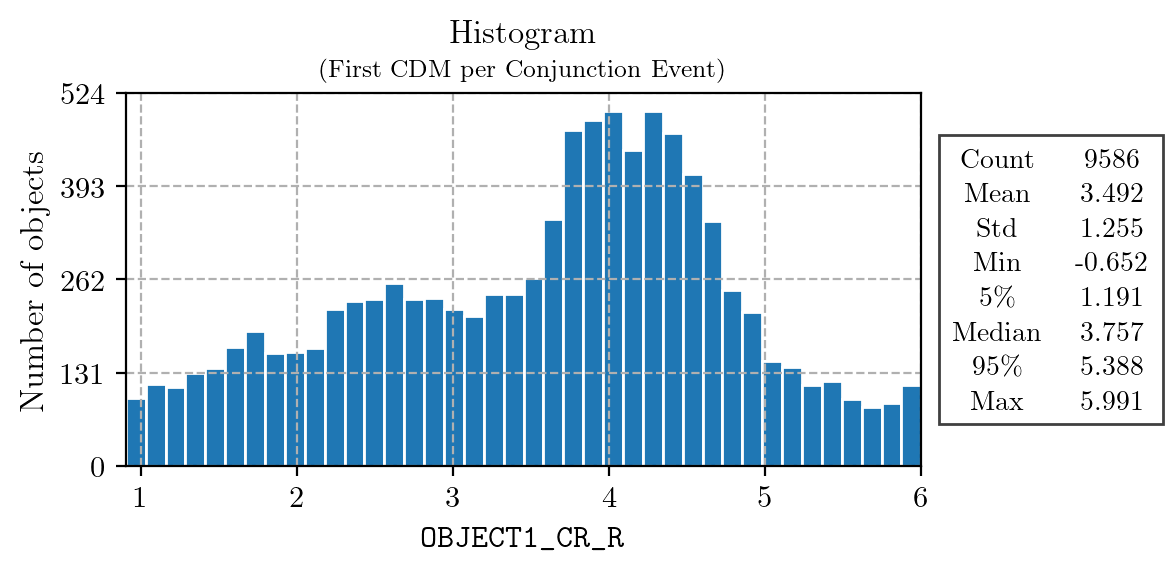

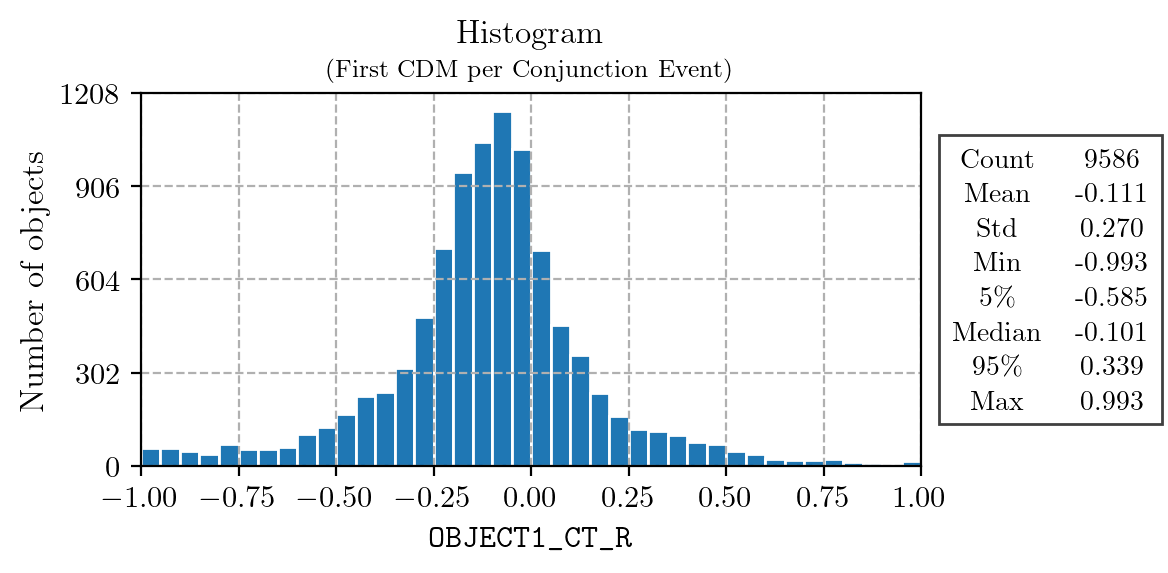

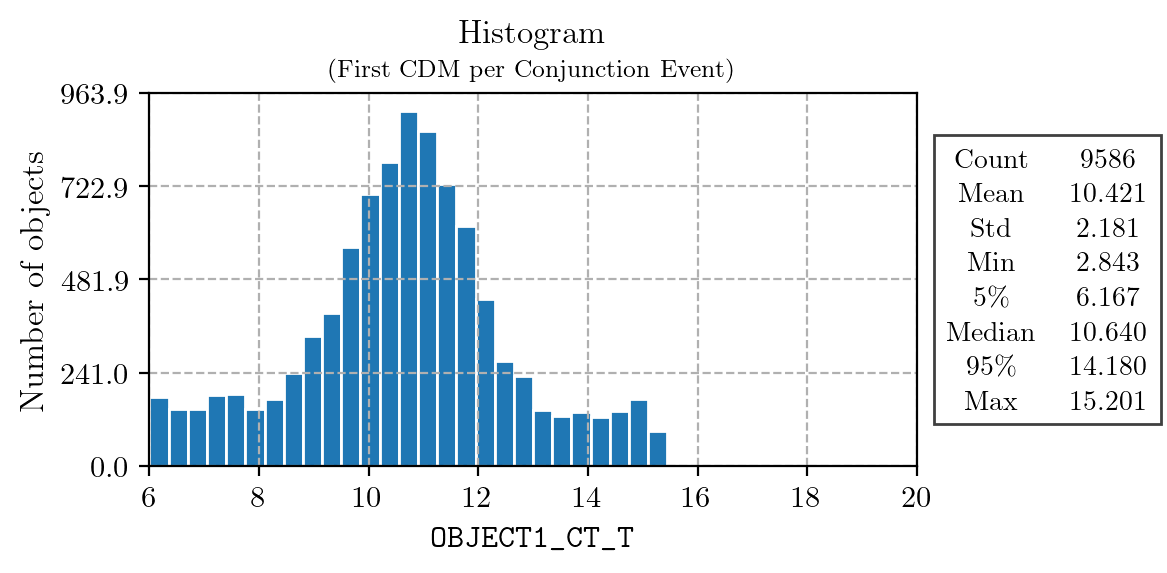

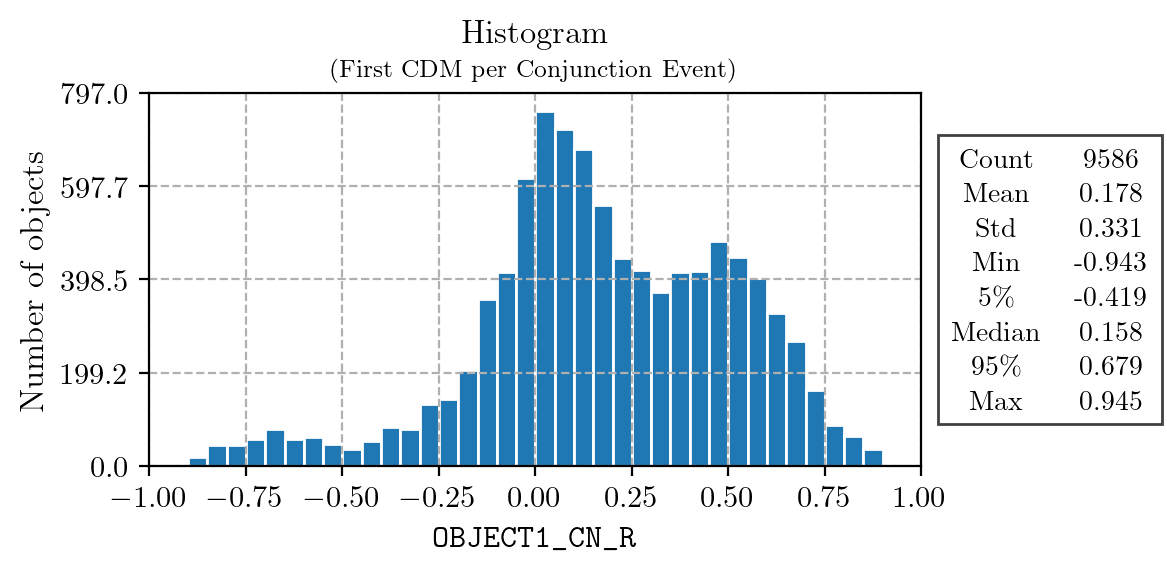

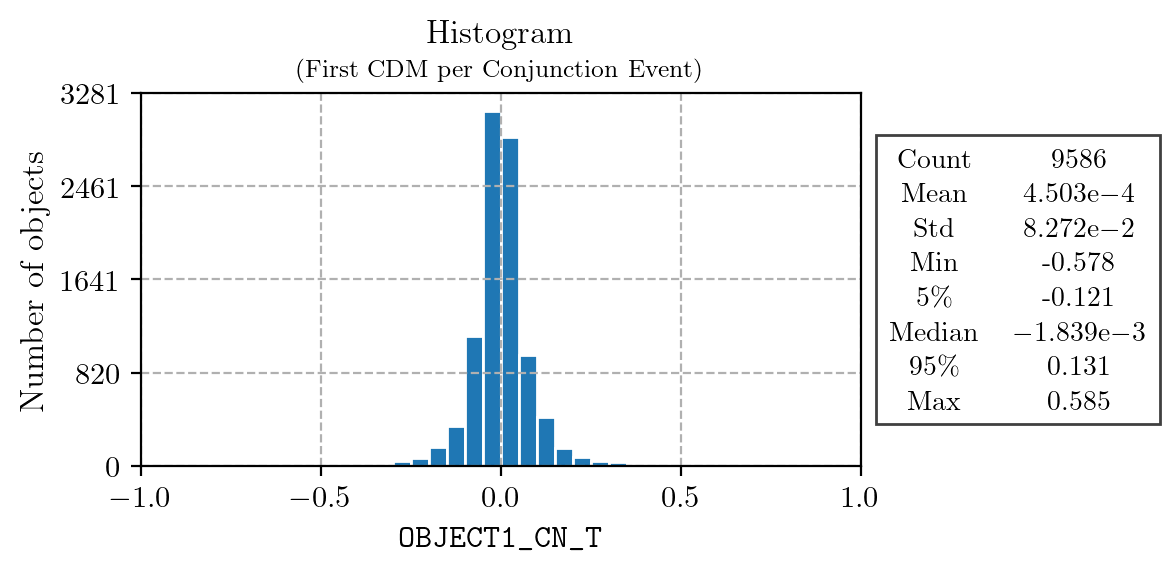

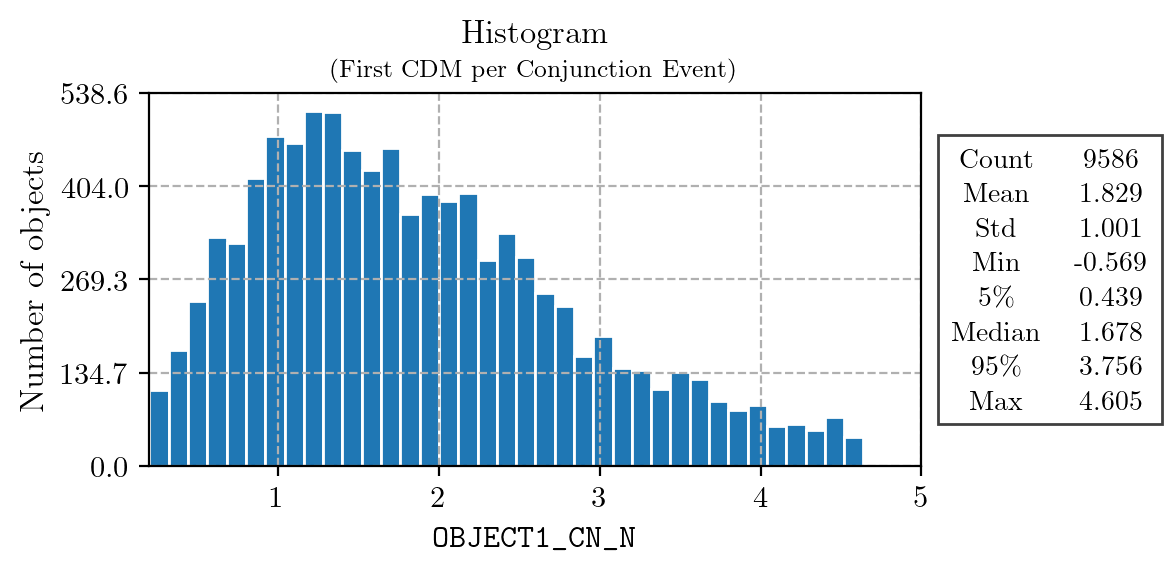

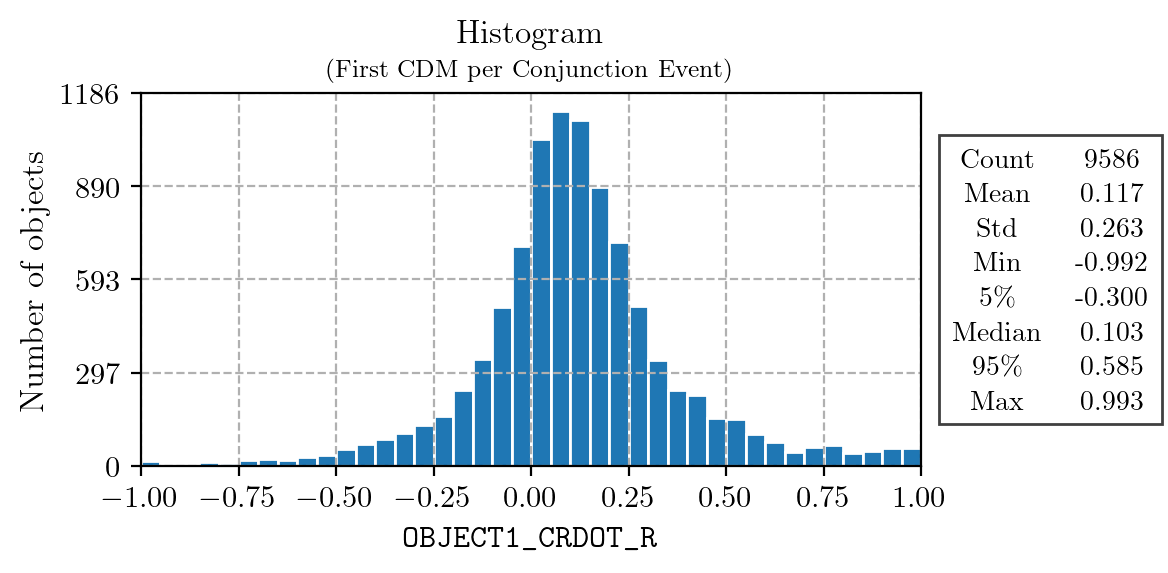

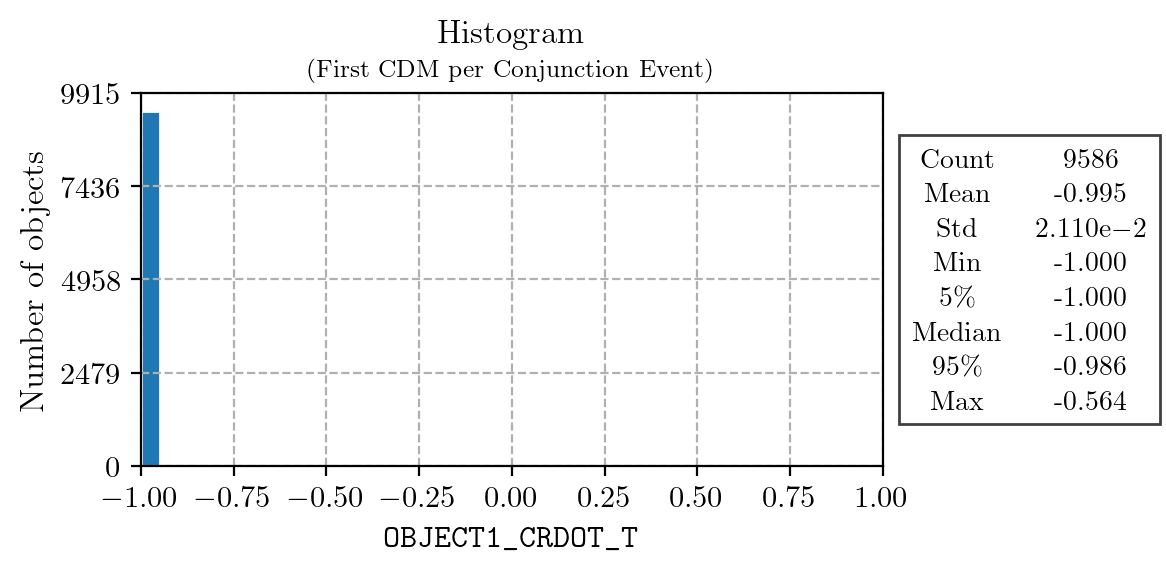

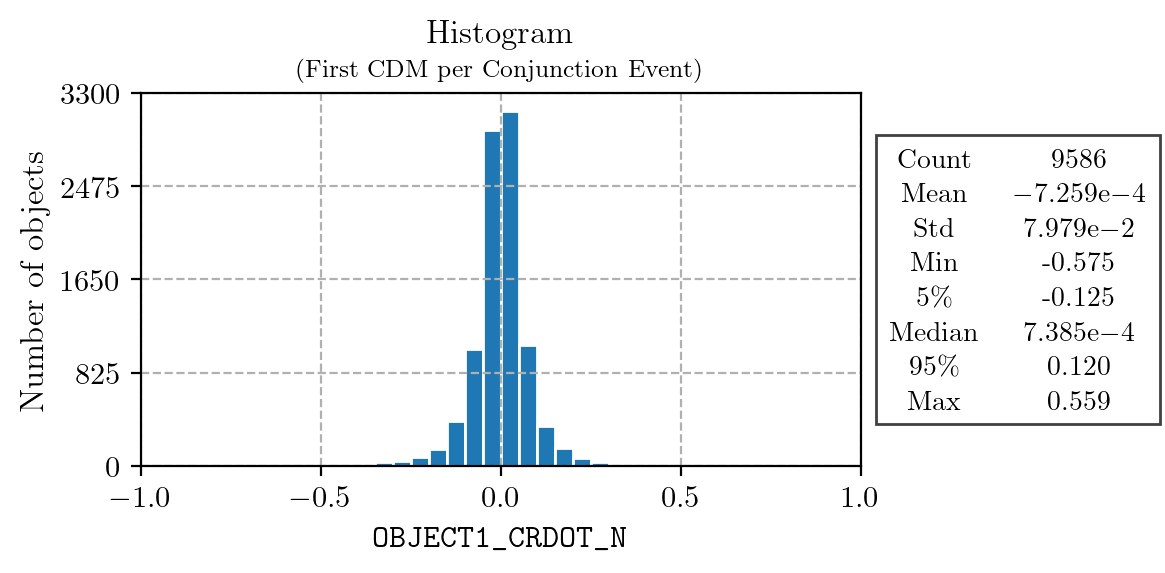

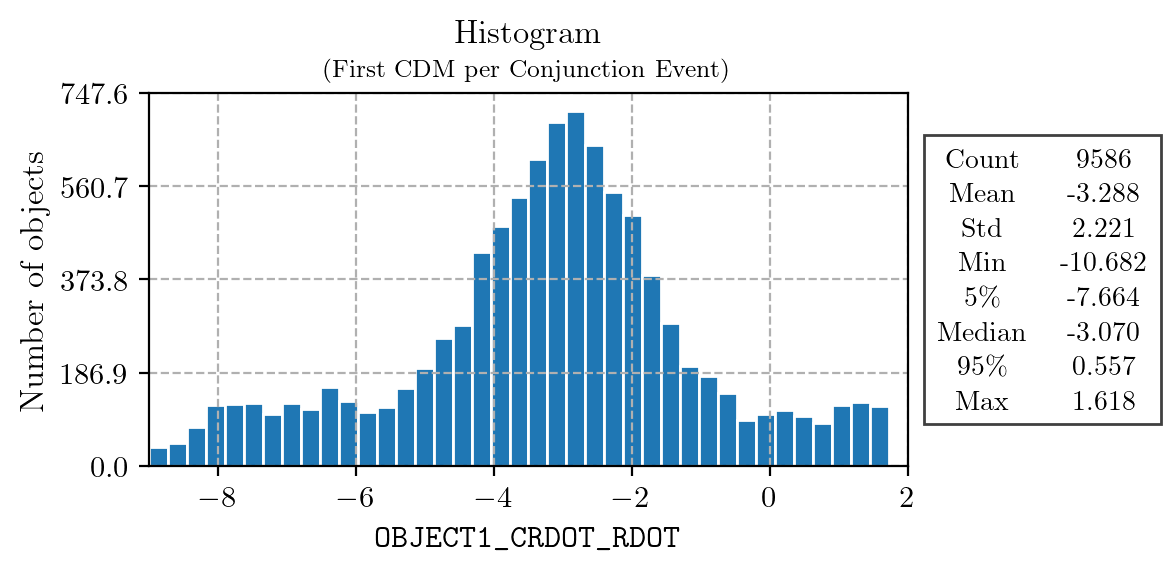

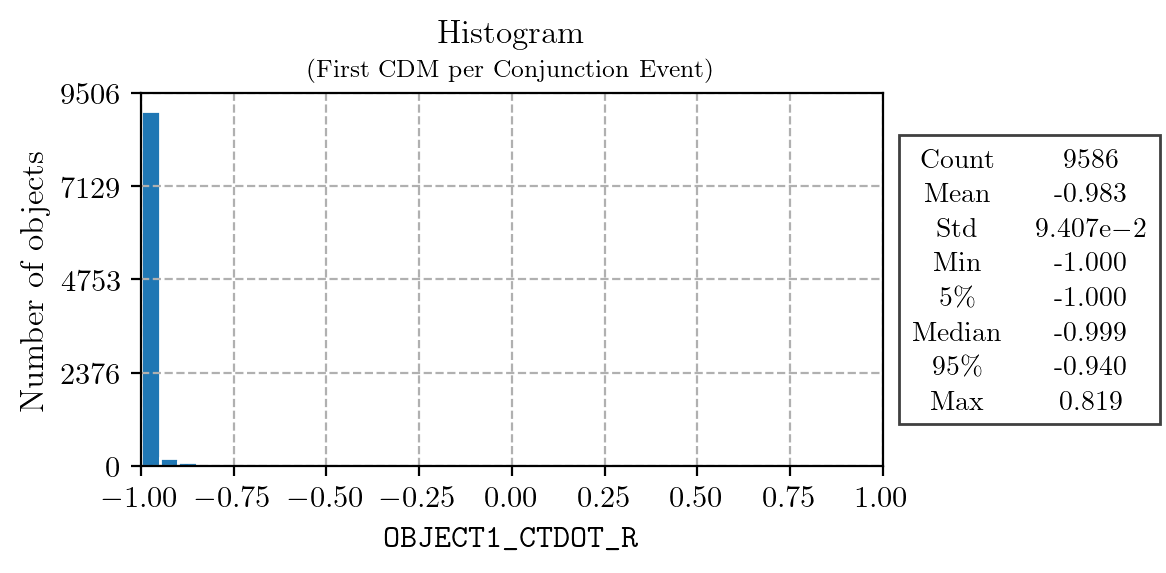

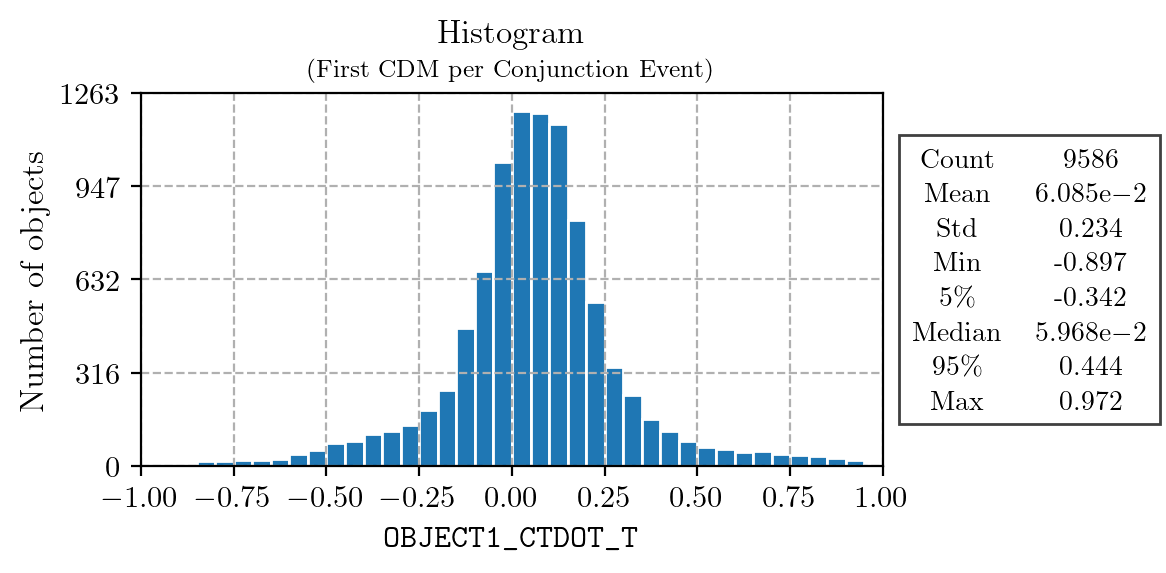

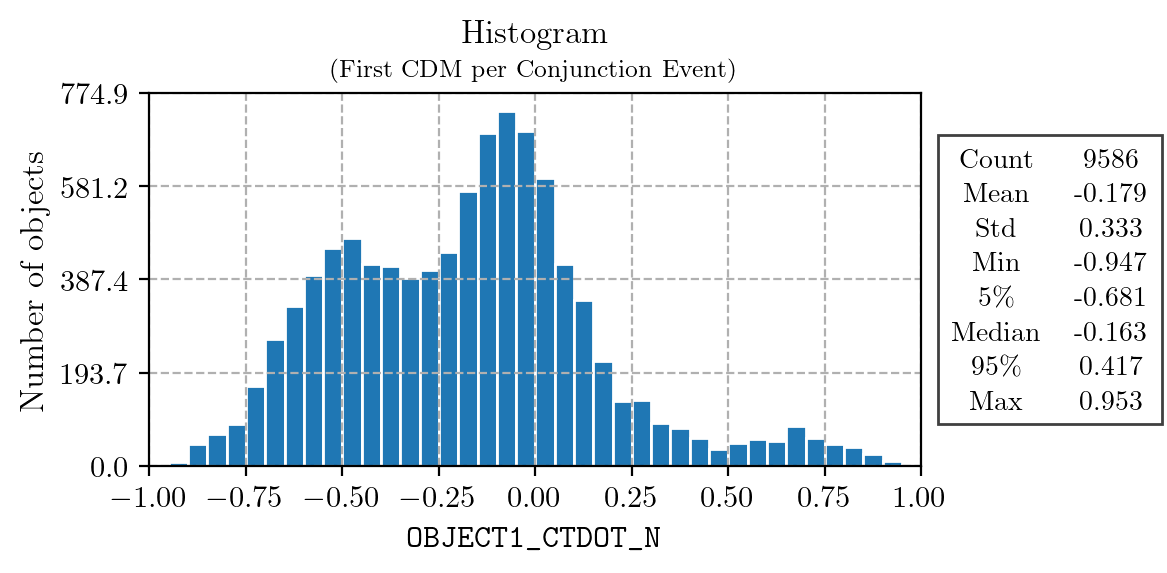

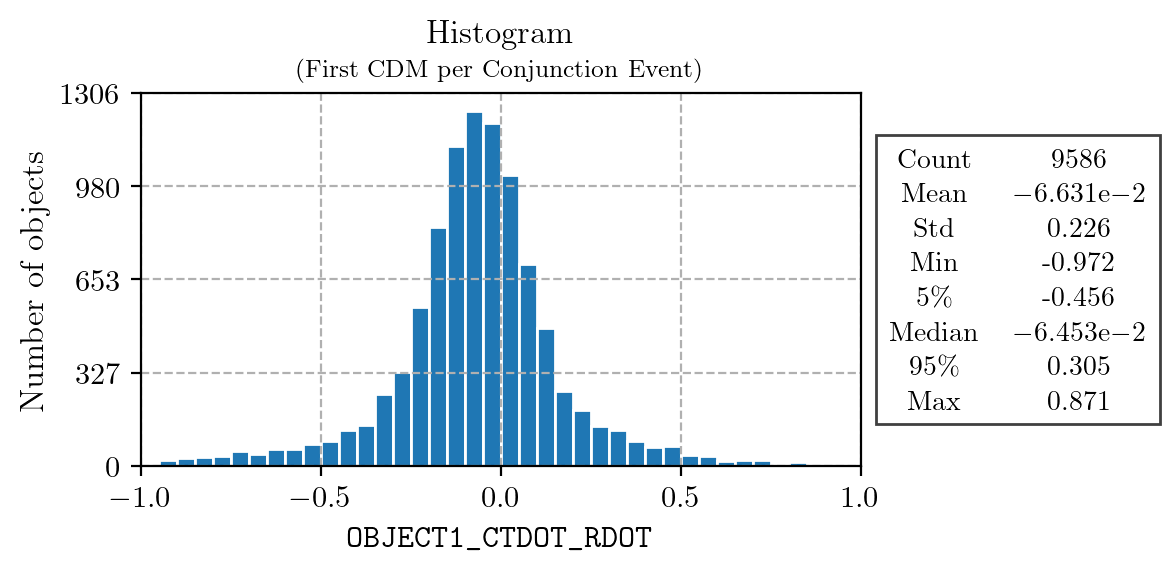

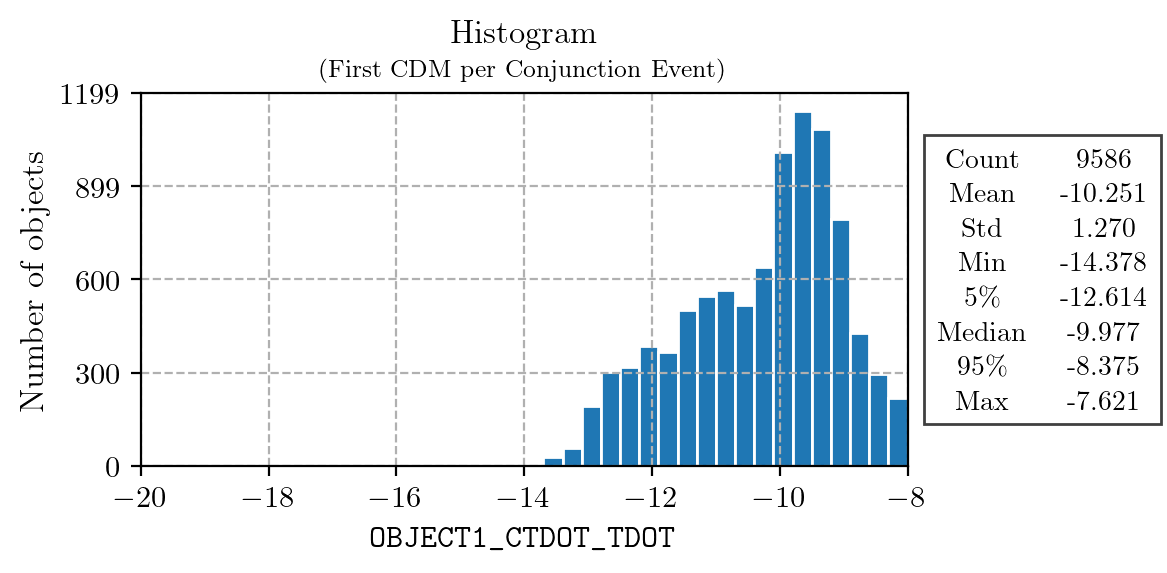

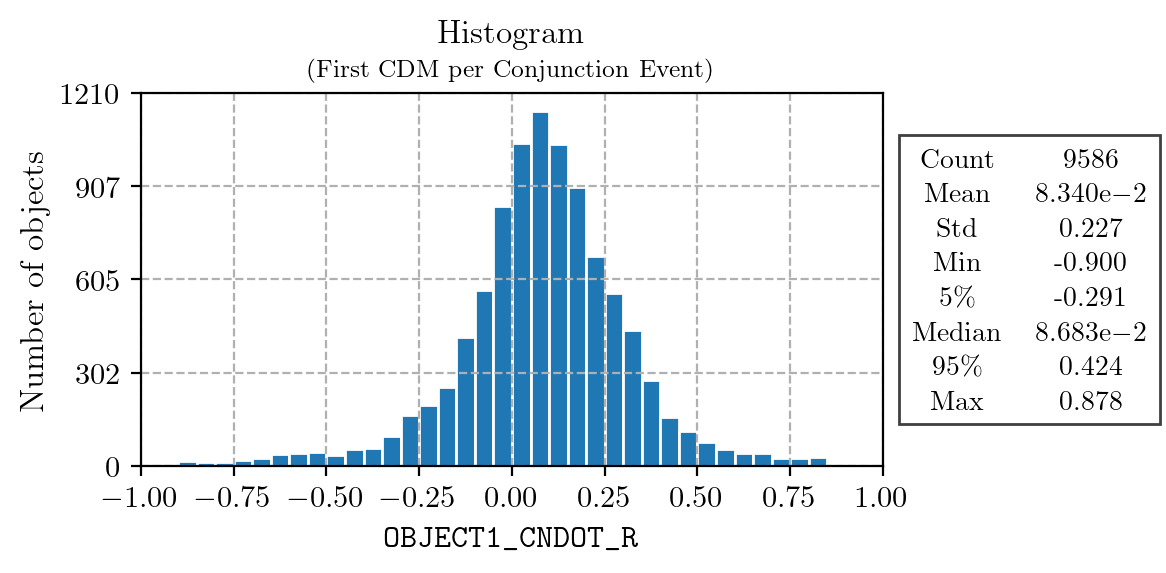

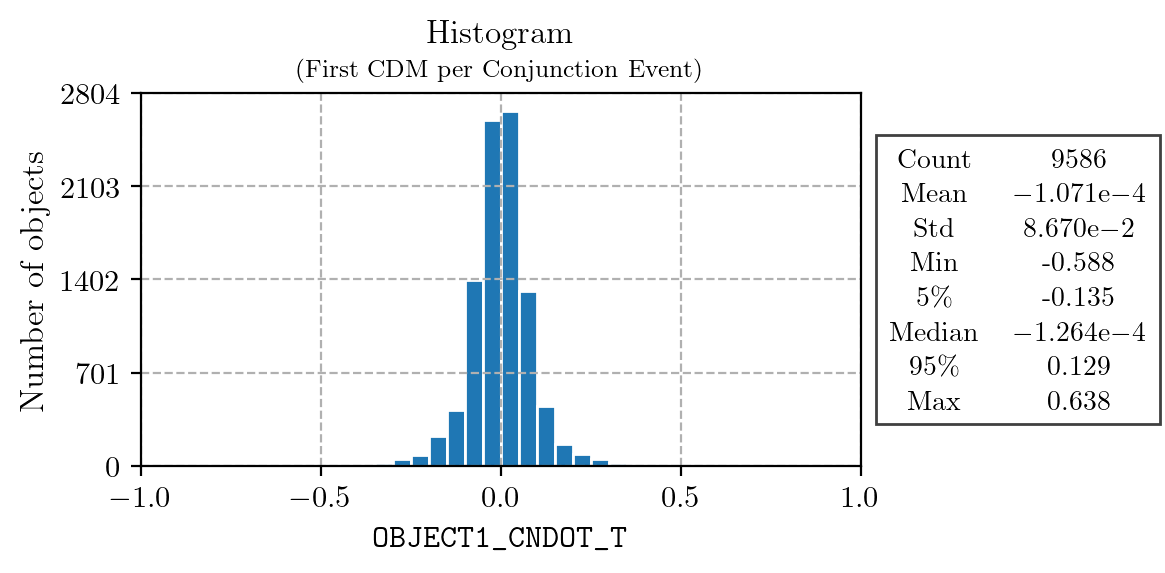

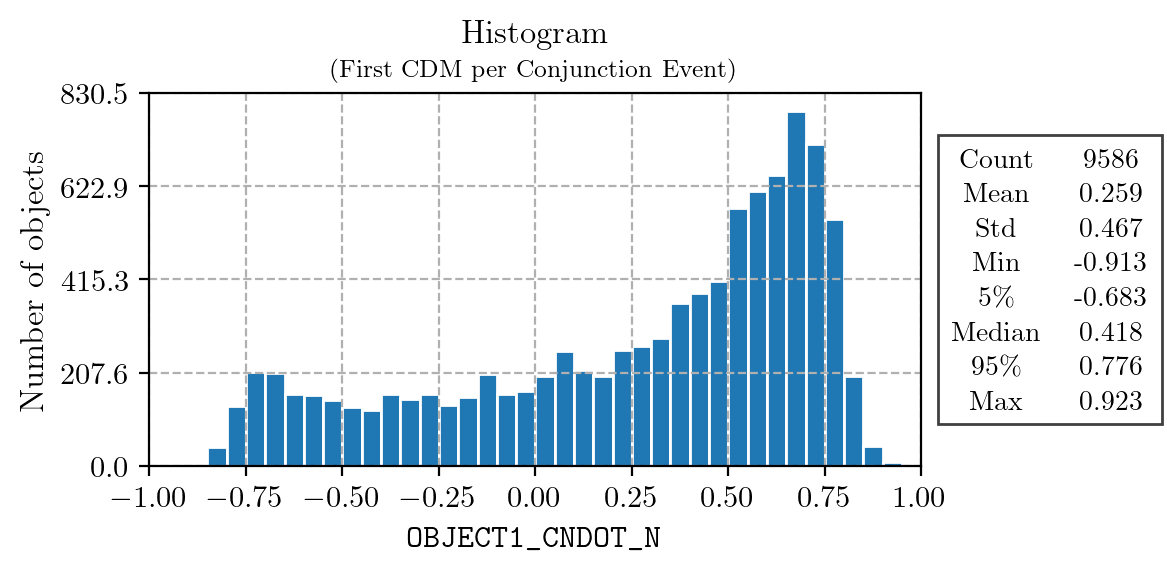

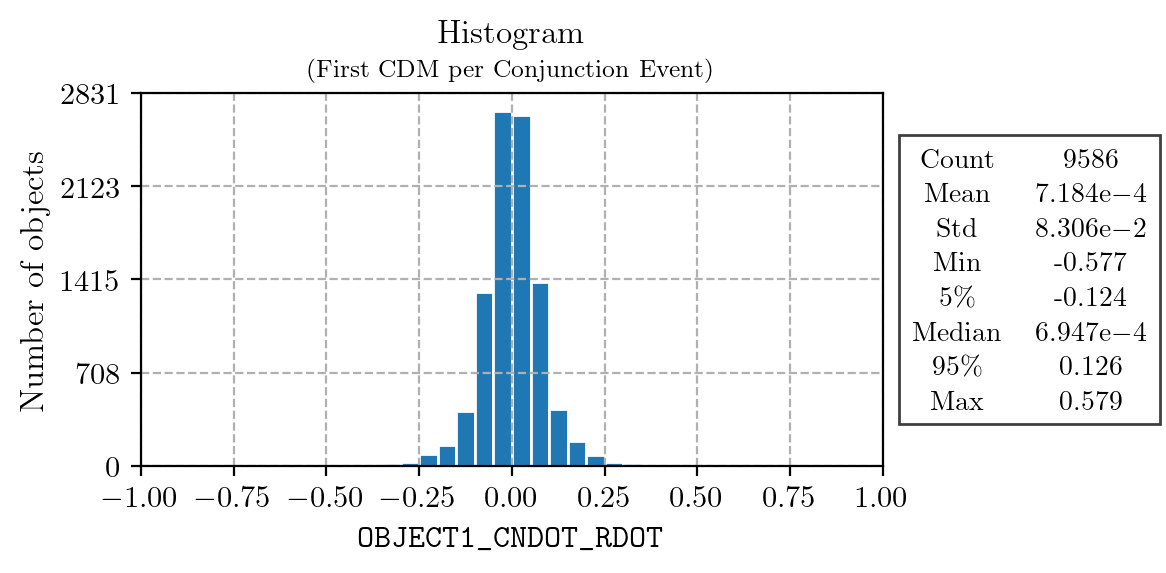

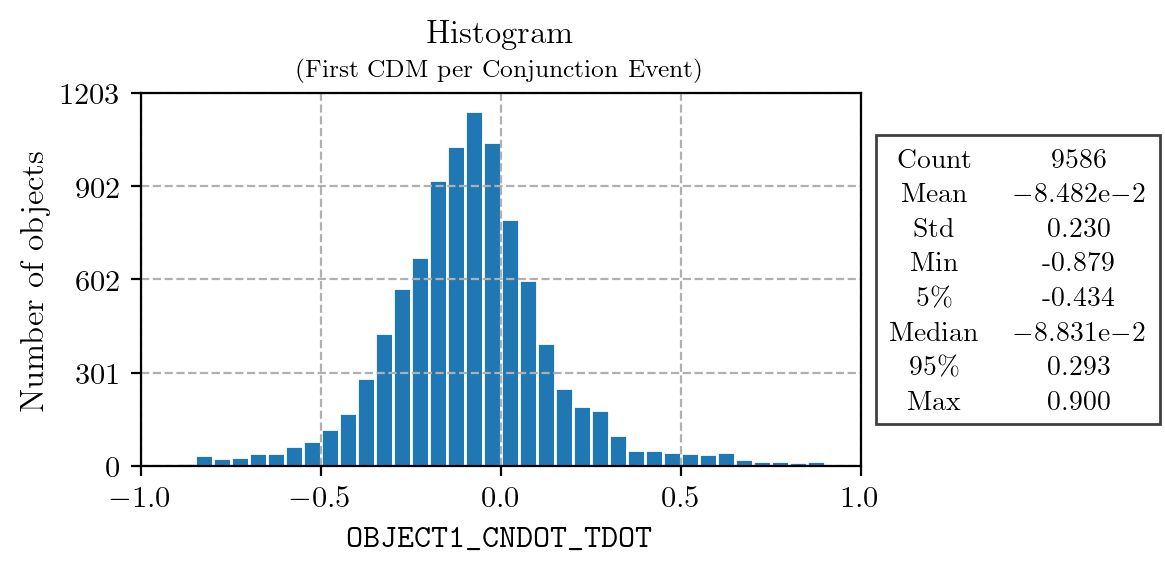

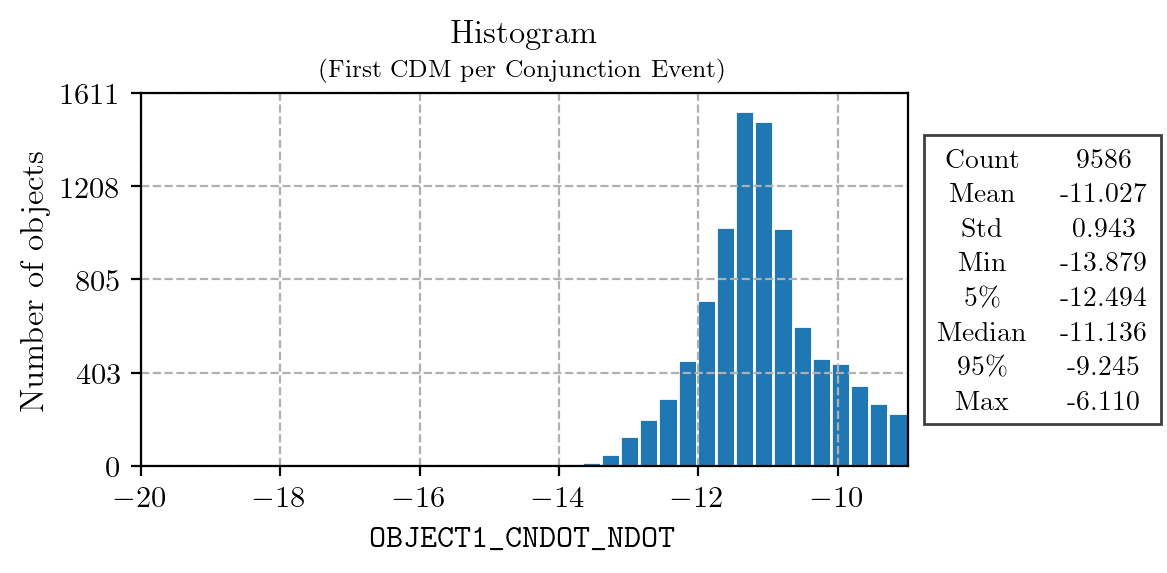

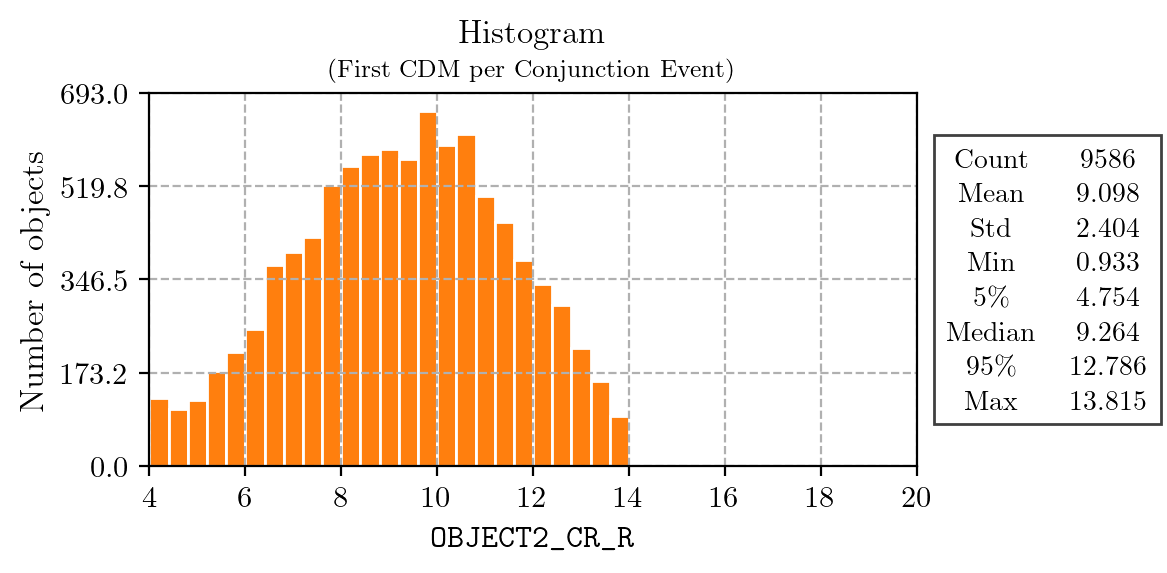

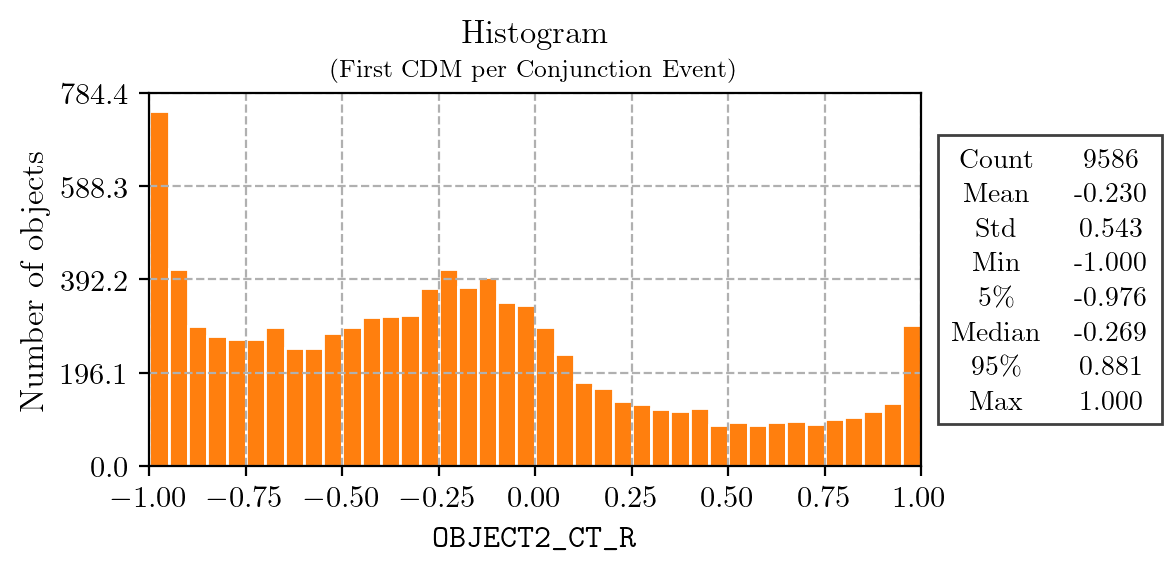

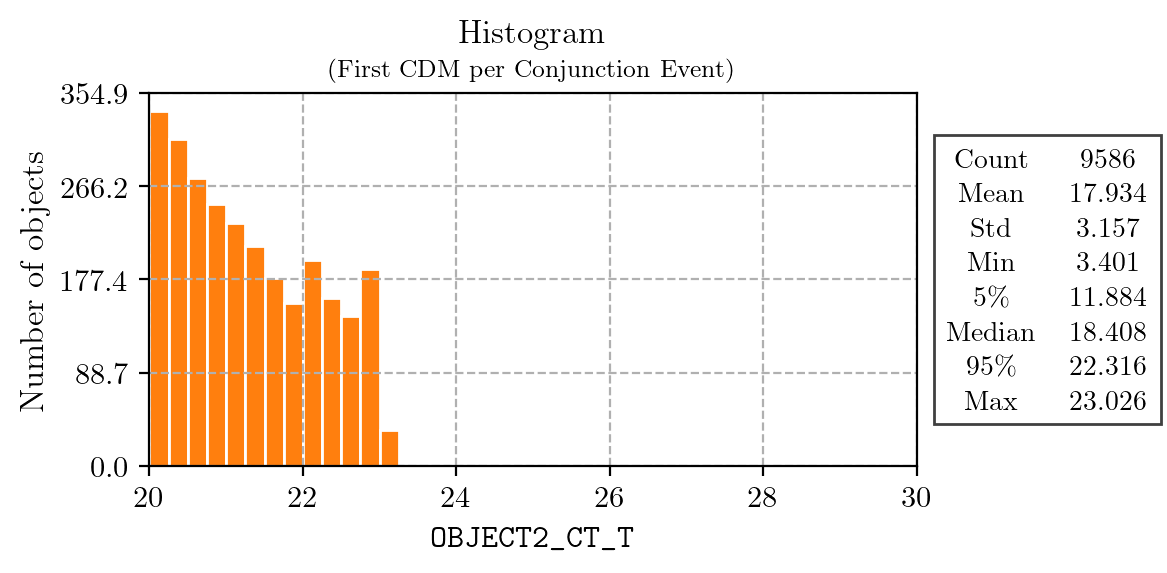

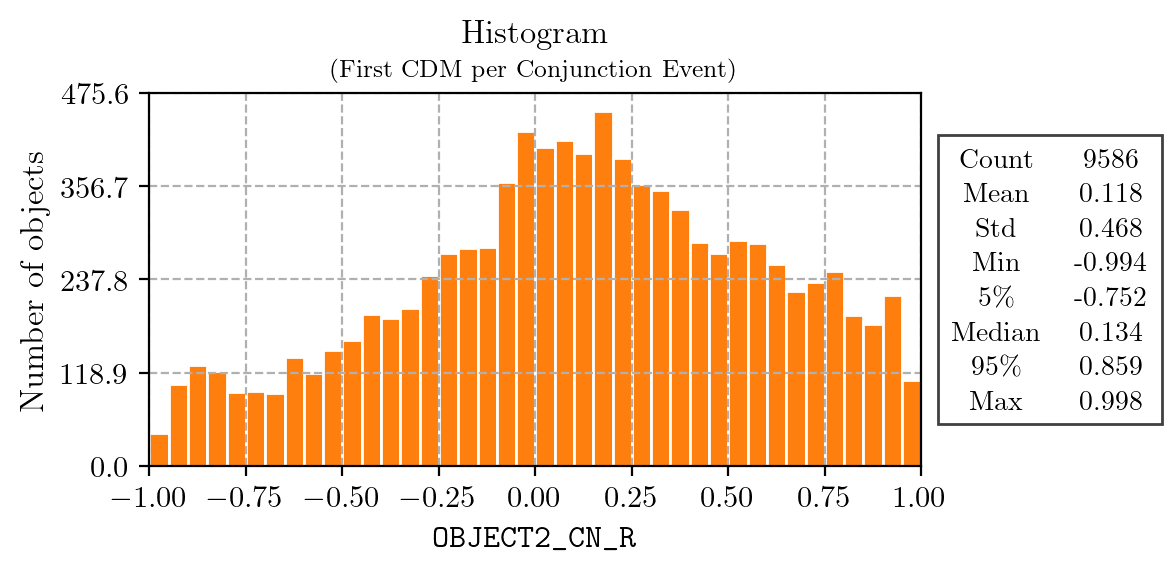

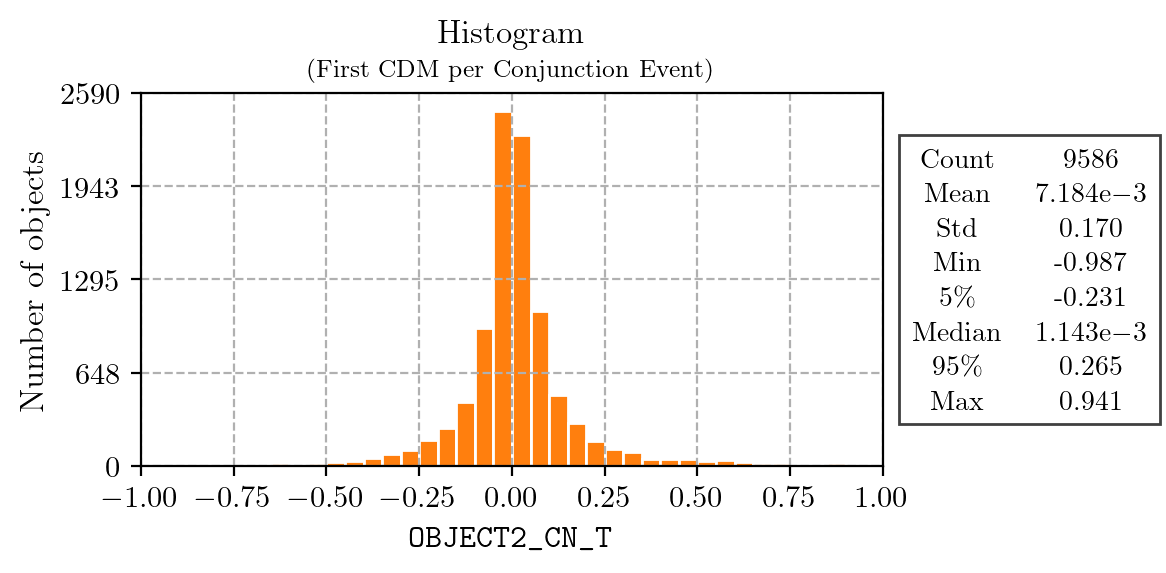

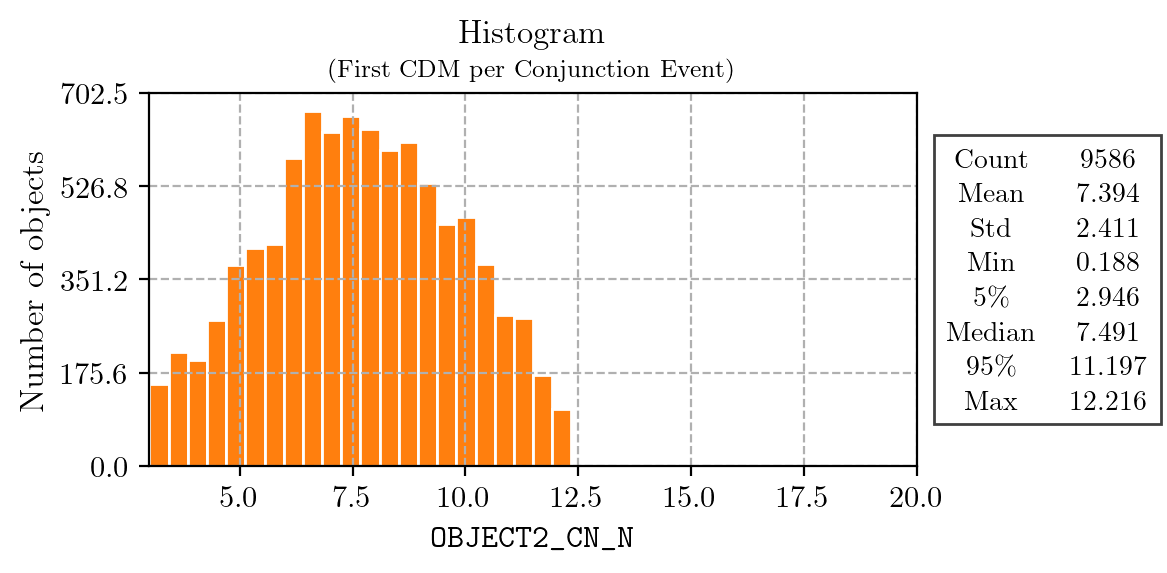

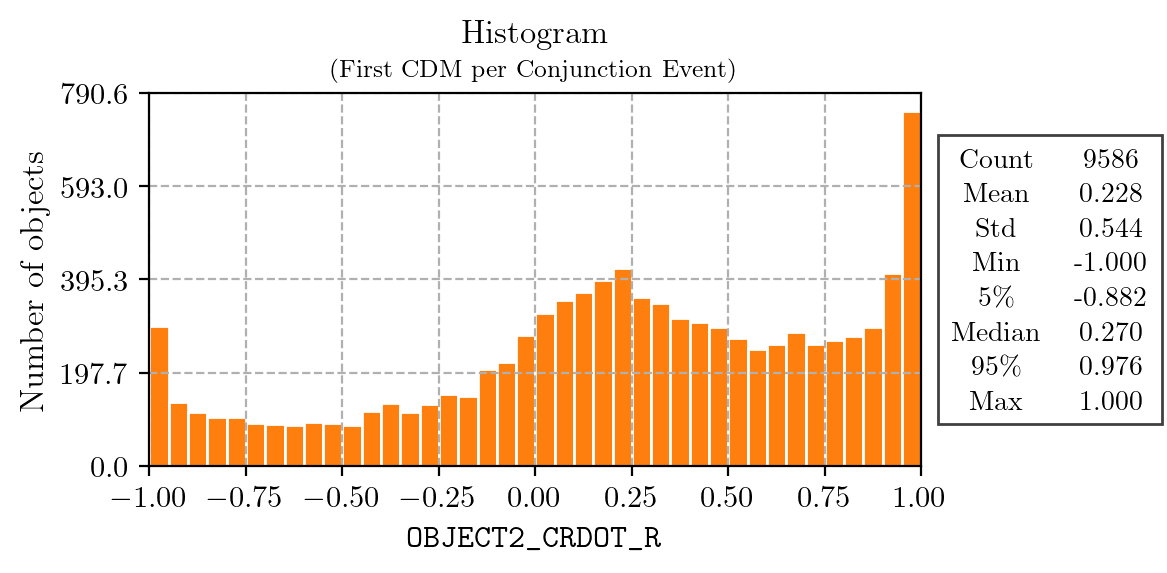

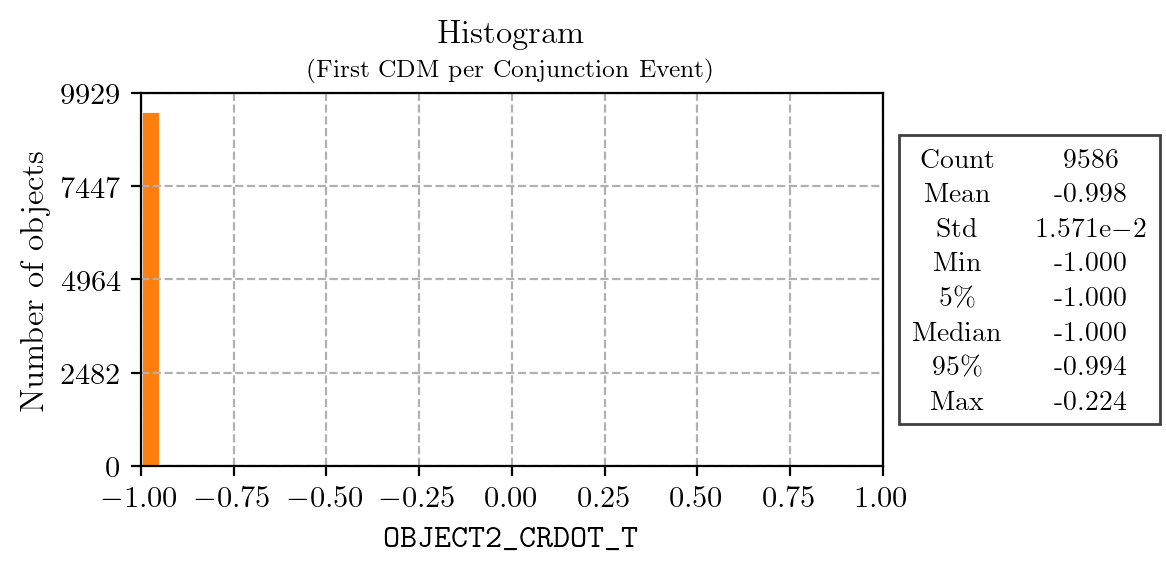

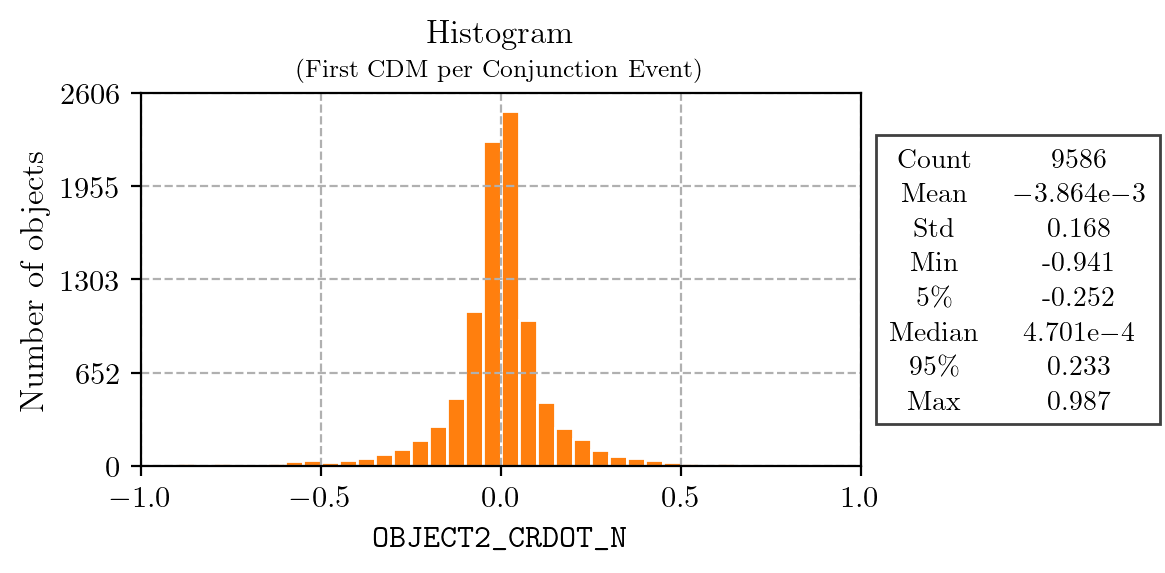

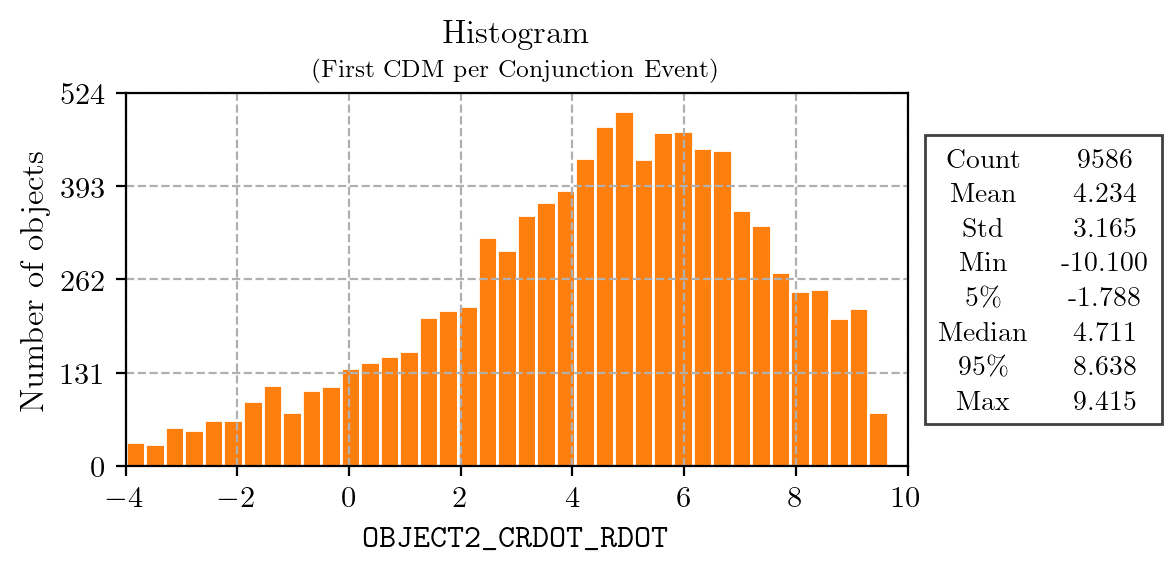

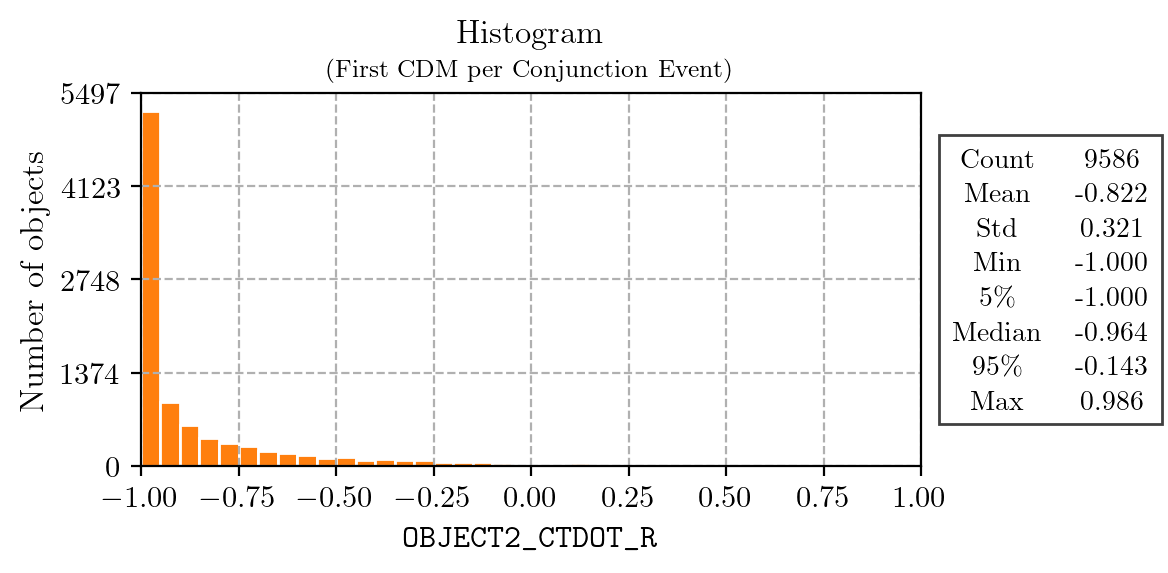

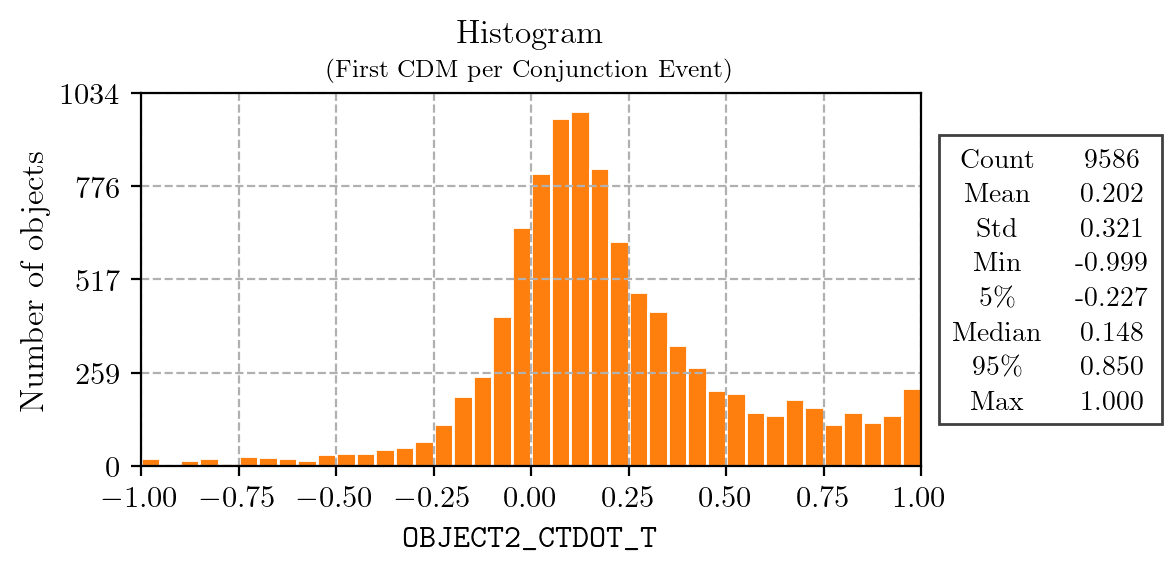

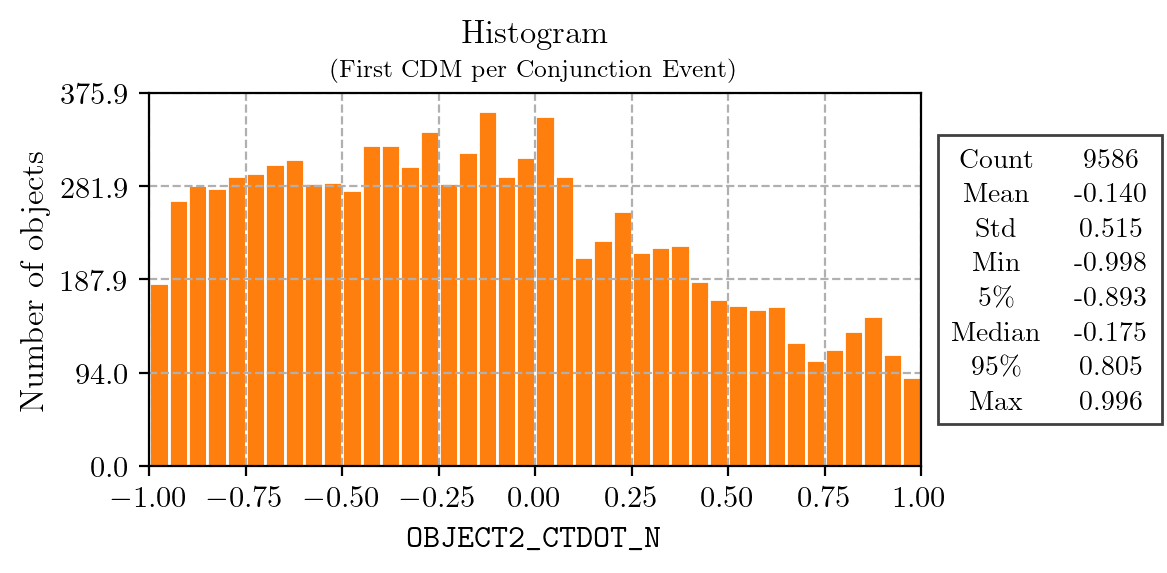

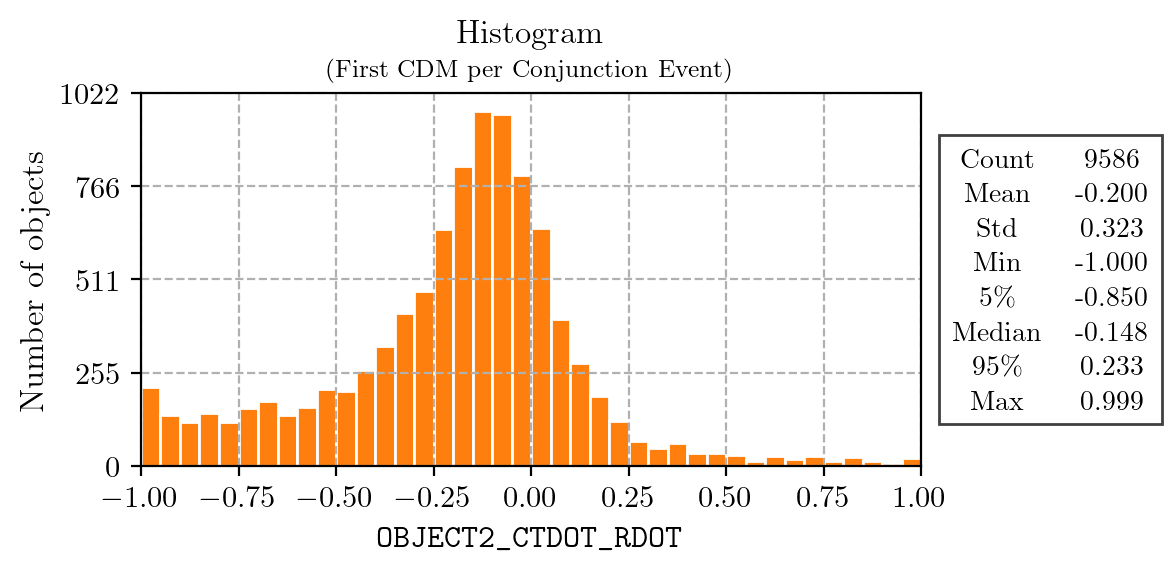

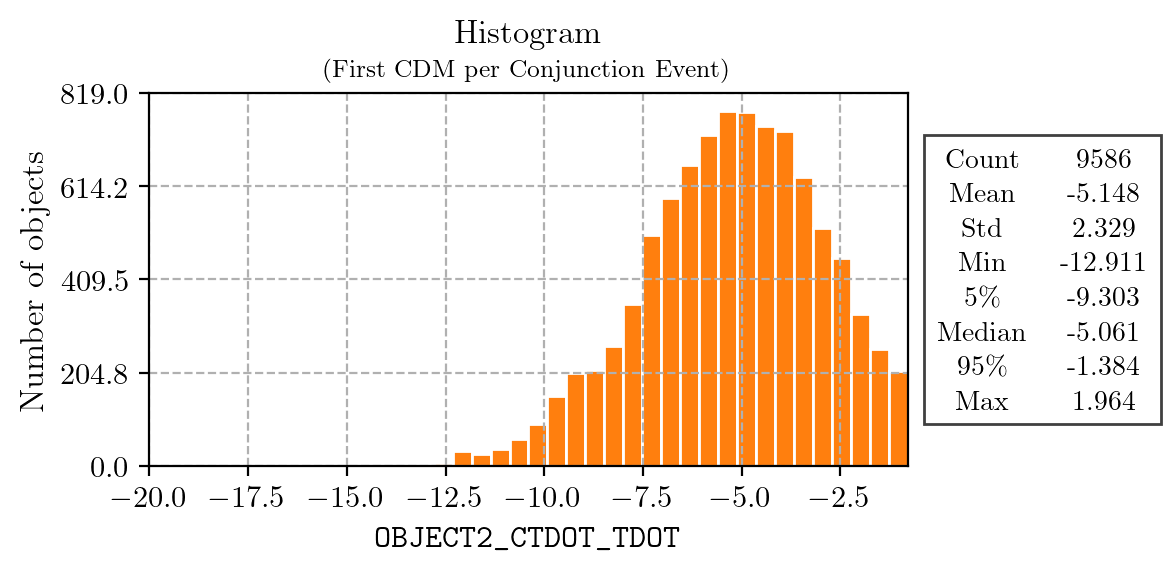

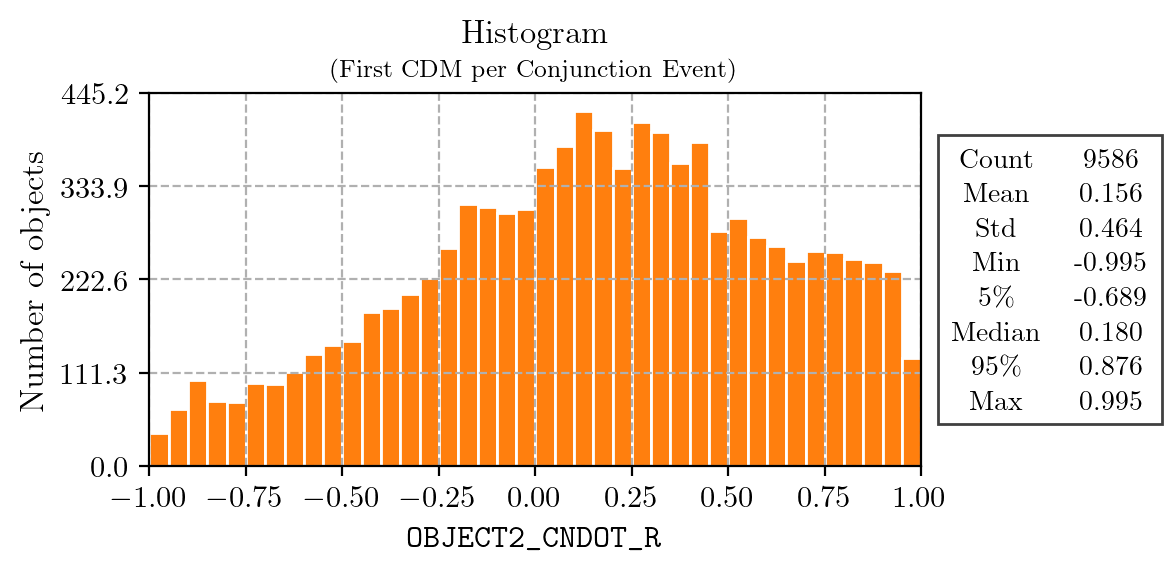

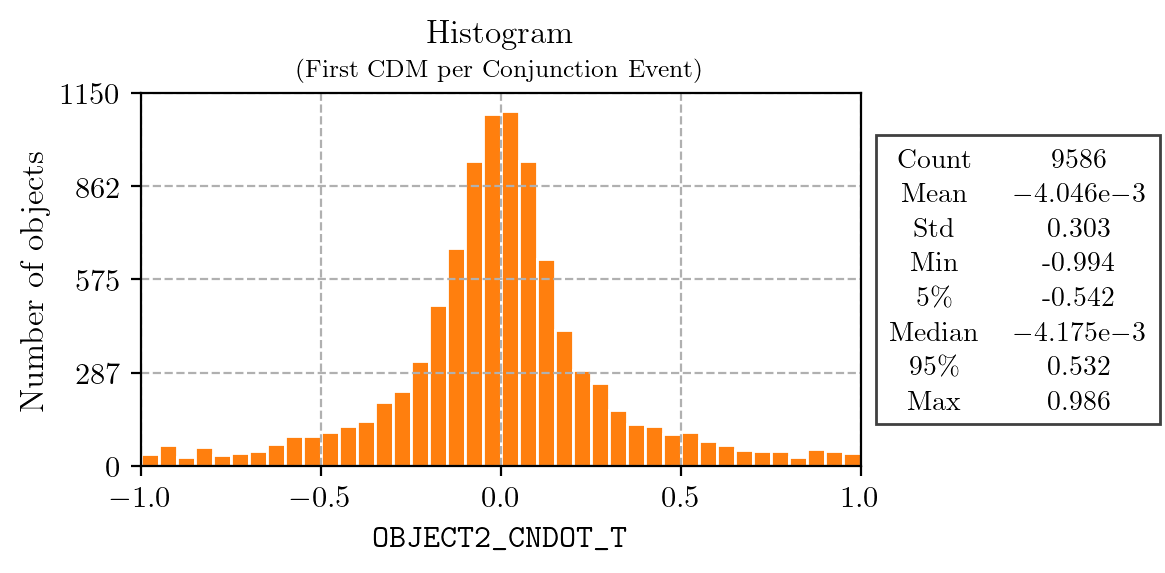

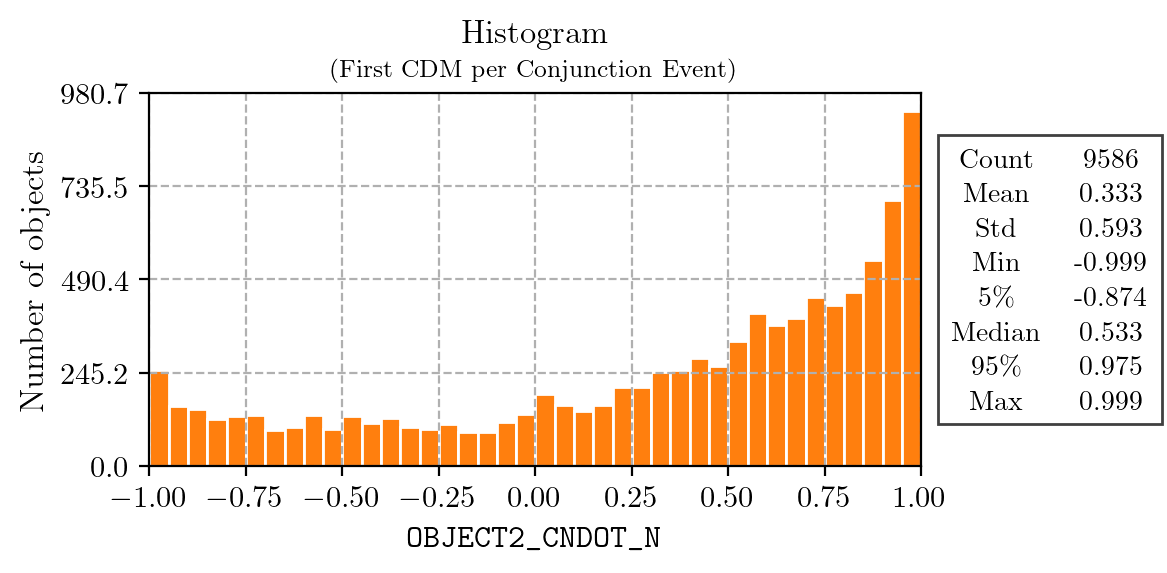

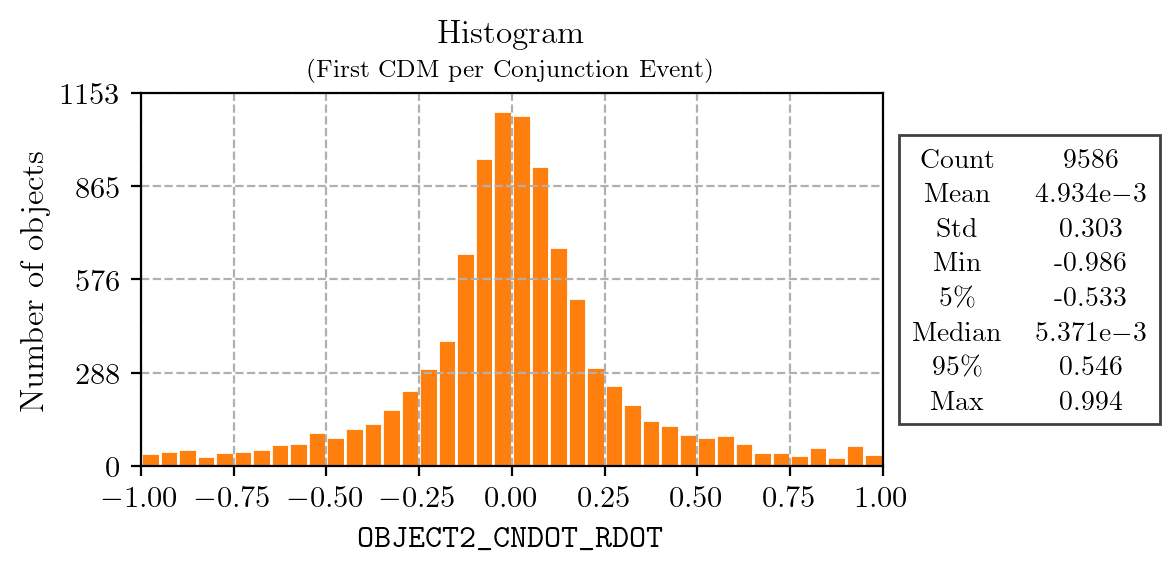

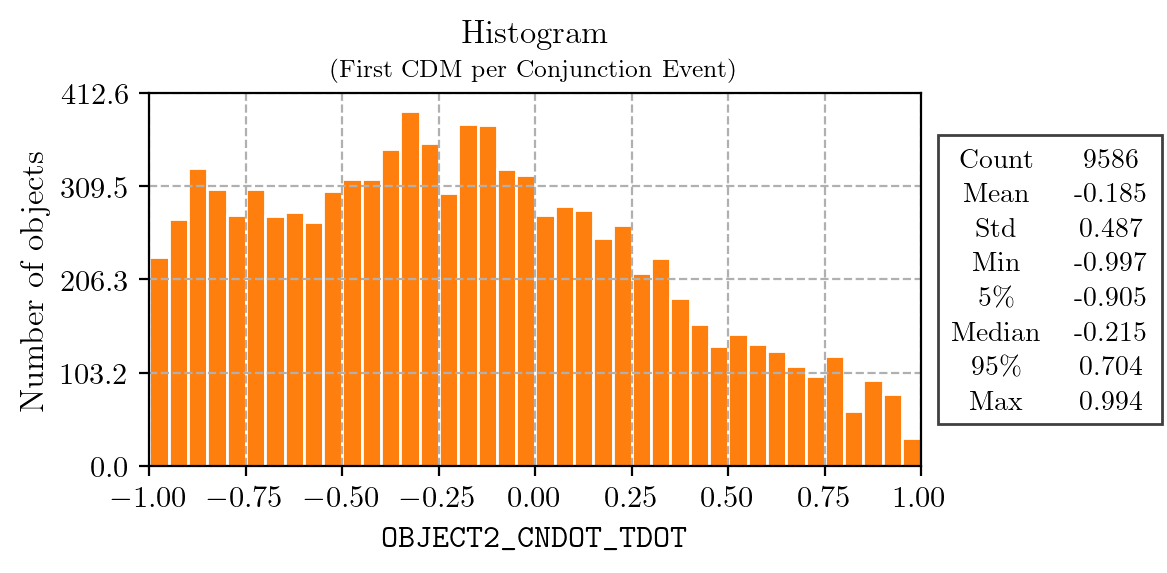

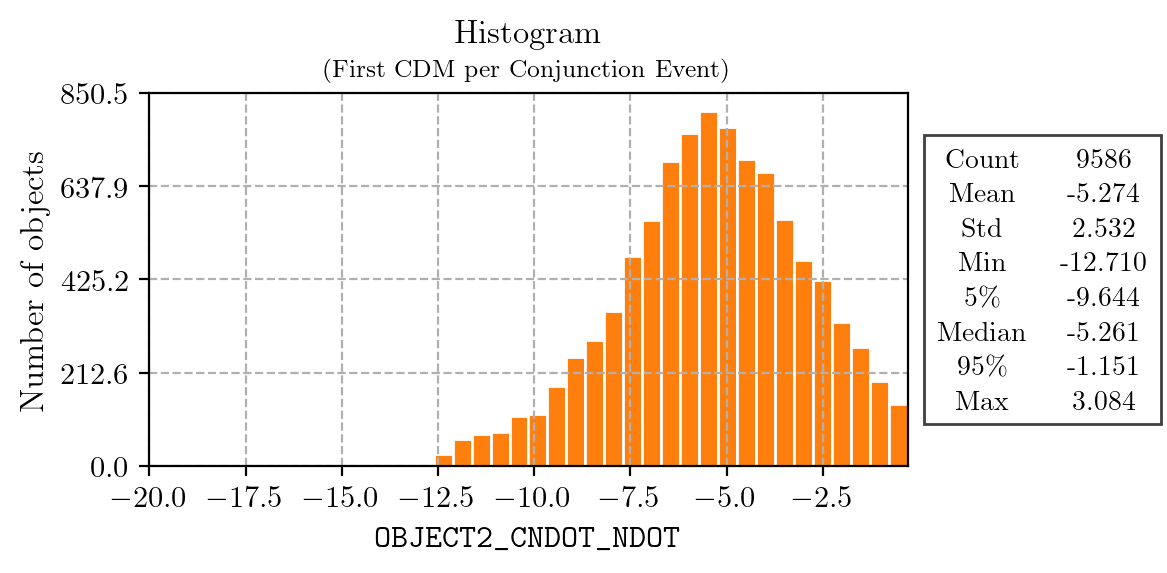

In [4]:
reload(eda)
reload(utils)
# Initialice list of covariance matrix components
rtn_components = ['R', 'T', 'N', 'RDOT', 'TDOT', 'NDOT']

dft_firstCDM = df_firstCDM.copy()

for o in [1, 2]:
    for feature in obligatory_features['data_covariance_obligatory']:

        # Get the RTN components from the feature
        i_rtn = feature.split('_')[0][1:]
        j_rtn = feature.split('_')[1]

        # Get variance of the components (used to scale the other terms of the
        # covariance matrix)
        i_sigma = df_firstCDM[f'OBJECT{o}_C{i_rtn}_{i_rtn}'].to_numpy()
        j_sigma = df_firstCDM[f'OBJECT{o}_C{j_rtn}_{j_rtn}'].to_numpy()

        # Get the feature name
        feature = f'OBJECT{o}_{feature}'

        # Switch the dataframe to use when plotting the feature.
        data = df_firstCDM[feature].to_numpy()

        # Check what element of the covariance matrix it is being processed.
        if i_rtn == j_rtn:
            # If feature is one of the main diagonal components (sigma), apply 
            # logarithmic scaling.
            data = np.log(data)
        else:
            # Otherwise scale covariance matrix element using the variances of
            # both components
            data = data/(i_sigma * j_sigma)**0.5

        # Update values in the DataFrame containing transformed data.
        dft_firstCDM[feature] = data

        # Plot histograms from conjunction measures
        filepath = os.path.join(utils.cwd,'notebooks','images', 'histograms', 
                                f'DATA_COVARIANCE-{feature}.pdf') 

        # Define kwargs for the histogram
        kwargs = {'title': f'Histogram\n \small (First CDM per Conjunction Event)', 
                'xlim':(-1,1) if i_rtn != j_rtn else None, 'filepath': filepath,
                'color':'tab:blue' if o==1 else 'tab:orange'}

        eda.plot_histogram(data, features=feature, show_stats=True, **kwargs)


## 3. - Synthetic CDM generation using Probability Density Estimation

[Introduction to Probability Density Estimation](https://machinelearningmastery.com/probability-density-estimation/)

From a statistical perspective, the best way to generate additional synthetic data that reliably mirrors the real data distribution is by analysing and estimating its probability density, that is, to understand how likely is to get a value from a continuous variable. Two techniques to estimate the Probability Density of all data distributions are used in the present EDA:

 - **Parametric**: the statistical distribution of the real data is described by an analytical and well-known statistical probability distribution by estimating the parameters implicit in the function. In this approach, a function is defined to find the statistical distribution that best fits the real data distribution of all existing continuous distributions available in [SciPy.org](https://docs.scipy.org/doc/scipy/reference/stats.html). The use of this method is limited to unimodal data distributions or data distributions with simple profiles.
 
 - **Non-parametric**: alternative method when the data distribution cannot be appropriately described analytically by a common probability distribution or cannot be easily made to fit the distribution (as it happens with multi-modal distributions). Among the multiple non-parametric methods available for Probability Density Estimation, the method used for estimating the probability density function of a continuous random variable in this analysis is the so-called *Kernel Density Estimation* (KDE). In particular the `KernelDensity` estimator from [Scikit-learn.org](https://scikit-learn.org/stable/modules/density.html) is used. More information on how this is done can be found in the following two articles:
 
     - [Histograms and KDE by Michael Lerner](https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html?p=28)
     - [Kernel Density Estimation in Python by Jake VanderPlas](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/)
 
The analysis developed in Section 2 on the different clusters data distributions supports the identification of those continuous variables that can be described using the parametric approach and those to be defined by the non-parametric one.

### 3.1.- Parametric Probability Density Estimation

The first approach to be considered when generating synthetic data is the parametric as it provides an excellent compromise between data distribution description accuracy and statistical simplicity based on assumptions about the shape of the distribution in the underlying population and about the form or parameters of the assumed distribution. However, not all features can be accurately described using the parametric approach and a reliable but simple enough criteria for its identification must be used.

In this regard, for the purposes of this EDA, the coefficient of determination $R^2$ between the actual and estimated probability densities is the parameter that determines whether a feature can be described using the parametric method. That is, those features for which the $R^2$ score between its actual and estimated probability density from an analytical statistical model is above a certain threshold (usually $R^2 \geq 0.95$) is considered good enough to be used to produce synthetic data.

In [5]:
features = []
for o in [1, 2]:
    for feature in obligatory_features['data_covariance_obligatory']:
        features += [f'OBJECT{o}_{feature}']

df = dft_firstCDM[features]

display(df.head(10))

,OBJECT1_CR_R,OBJECT1_CT_R,OBJECT1_CT_T,OBJECT1_CN_R,OBJECT1_CN_T,OBJECT1_CN_N,OBJECT1_CRDOT_R,OBJECT1_CRDOT_T,OBJECT1_CRDOT_N,OBJECT1_CRDOT_RDOT,OBJECT1_CTDOT_R,OBJECT1_CTDOT_T,OBJECT1_CTDOT_N,OBJECT1_CTDOT_RDOT,OBJECT1_CTDOT_TDOT,OBJECT1_CNDOT_R,OBJECT1_CNDOT_T,OBJECT1_CNDOT_N,OBJECT1_CNDOT_RDOT,OBJECT1_CNDOT_TDOT,OBJECT1_CNDOT_NDOT,OBJECT2_CR_R,OBJECT2_CT_R,OBJECT2_CT_T,OBJECT2_CN_R,OBJECT2_CN_T,OBJECT2_CN_N,OBJECT2_CRDOT_R,OBJECT2_CRDOT_T,OBJECT2_CRDOT_N,OBJECT2_CRDOT_RDOT,OBJECT2_CTDOT_R,OBJECT2_CTDOT_T,OBJECT2_CTDOT_N,OBJECT2_CTDOT_RDOT,OBJECT2_CTDOT_TDOT,OBJECT2_CNDOT_R,OBJECT2_CNDOT_T,OBJECT2_CNDOT_N,OBJECT2_CNDOT_RDOT,OBJECT2_CNDOT_TDOT,OBJECT2_CNDOT_NDOT
0,2.801347,-0.397969,9.848951,0.292258,0.040799,1.154820,0.394221,-0.999674,-0.038498,-3.829888,-0.981098,0.214612,-0.316493,-0.210247,-10.997512,0.170737,-0.001551,0.531593,0.002117,-0.179278,-11.627257,11.172416,-0.824859,21.807020,0.473976,-0.002576,7.683741,0.825216,-0.999998,0.003565,8.130247,-0.732954,0.220006,-0.814249,-0.220621,-3.603089,0.249855,0.196620,0.722186,-0.196908,-0.668487,-1.901443
5,3.739644,-0.134713,11.110971,0.126515,-0.023597,3.111365,0.108845,-0.998856,0.018619,-2.557722,-0.999598,0.107629,-0.126921,-0.081454,-9.929384,-0.096789,-0.082136,0.810101,0.085601,0.099044,-10.945961,8.364504,-0.858928,22.527199,0.106509,0.325019,7.875554,0.858976,-1.000000,-0.324987,8.877698,-0.910190,0.993879,0.240336,-0.993890,-2.274985,-0.682288,0.812345,0.224426,-0.812406,0.803415,-6.098913
9,4.403099,-0.099768,9.989217,0.357995,-0.122174,0.992620,0.085472,-0.999674,0.121504,-3.750303,-0.999114,0.057809,-0.353866,-0.043471,-9.340532,-0.025138,0.087954,-0.430583,-0.088821,0.021409,-11.100799,11.099772,-0.068526,21.099790,0.636970,-0.038214,10.771225,0.064305,-0.999989,0.036762,7.362478,-0.996314,0.153806,-0.634961,-0.149627,-2.618924,0.715984,-0.159057,0.953945,0.156803,-0.723349,-2.161119
29,3.480322,-0.087312,12.251246,0.098330,0.033053,1.981860,0.061782,-0.999429,-0.034312,-1.462967,-0.999151,0.046797,-0.099833,-0.021124,-10.227397,0.077394,-0.011649,0.336194,0.013638,-0.076656,-9.141744,9.486474,-0.737034,20.003440,0.536613,0.050497,9.514143,0.736885,-0.999998,-0.050083,6.296712,-0.813999,0.207397,-0.818841,-0.207178,-4.969111,0.507124,0.124765,0.970631,-0.124688,-0.840472,-2.002078
50,4.259142,-0.331147,11.434297,-0.107863,0.070392,3.804487,0.278666,-0.997821,-0.065769,-2.305406,-0.997851,0.269174,0.105238,-0.215500,-9.471053,0.158920,0.007587,0.349890,-0.008566,-0.160701,-10.336490,8.580397,-0.710071,20.033075,0.428043,0.031449,7.368530,0.709902,-0.999999,-0.031064,6.319652,-0.962811,0.493592,-0.540773,-0.493384,-5.556776,0.245195,0.198757,0.905918,-0.198620,-0.379112,-5.098563
59,4.365589,-0.136875,12.395741,0.485823,-0.045550,1.171318,0.125997,-0.999900,0.041702,-1.273665,-0.999395,0.102475,-0.486133,-0.091553,-9.307340,0.216423,0.047884,0.524558,-0.050111,-0.219126,-11.027664,4.259246,-0.119671,13.023073,0.006362,-0.001349,1.246260,0.112350,-0.999948,0.003352,-0.644636,-0.999148,0.078779,-0.006006,-0.071428,-9.413118,0.017923,0.091939,0.590005,-0.091542,-0.021738,-10.815326
79,1.837053,-0.177303,10.595374,-0.307325,-0.080800,0.698147,0.269707,-0.992599,0.013902,-3.112491,-0.991375,0.047979,0.315500,-0.141564,-11.920342,0.626576,0.095186,-0.350239,0.001422,-0.641244,-10.010989,6.271386,-0.241079,16.459663,-0.131872,0.025034,6.733325,0.236489,-0.999975,-0.024864,2.746666,-0.988883,0.095242,0.134306,-0.090534,-7.494664,-0.106681,0.105327,0.897595,-0.105549,0.096127,-6.609283
100,4.557839,-0.236909,9.737196,0.268608,-0.030482,2.432904,0.222480,-0.999140,0.035452,-4.018659,-0.999685,0.212550,-0.269070,-0.198040,-9.204663,0.152707,-0.006746,0.522503,0.012896,-0.153203,-9.760459,12.028081,0.177192,17.441789,0.987688,0.148964,10.372350,-0.226883,-0.998673,-0.197193,3.707145,-0.998410,-0.121433,-0.987628,0.171624,-1.748908,0.398986,0.125264,0.520915,-0.137203,-0.395248,-3.810539
120,3.818136,-0.153775,12.708038,0.067323,0.028306,1.882060,0.172539,-0.999782,-0.02

Parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/sdg/SDG-OBJECT1_CR_R.pkl
Parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/sdg/SDG-OBJECT1_CT_R.pkl
Parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/sdg/SDG-OBJECT1_CT_T.pkl
Parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/sdg/SDG-OBJECT1_CN_R.pkl
Parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/sdg/SDG-OBJECT1_CN_T.pkl
Parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/sdg/SDG-OBJECT1_CN_N.pkl
Parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/sdg/SDG-OBJECT1_CRDOT_R.pkl
Parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/sdg/SDG-OBJECT1_CRDOT_T.pkl
Parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/sdg/SDG-OBJECT1_CRDOT_N.pkl
Parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/sdg/SDG-OBJECT1_CRDOT_RDOT.pkl
Parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/sdg/SDG-OBJECT1_CTDOT_R.pkl
Par

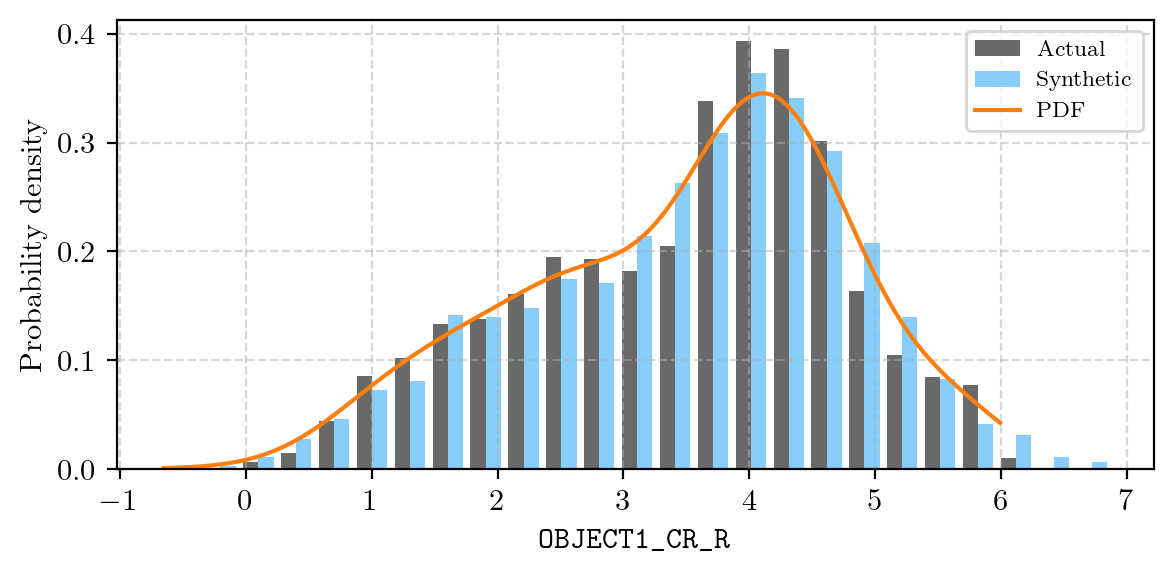

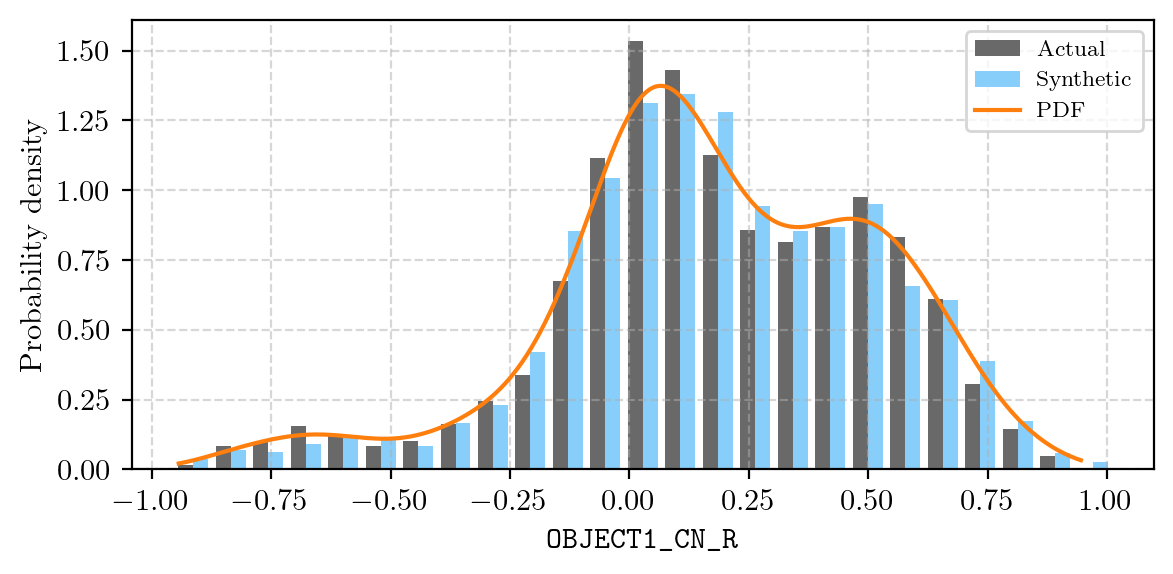

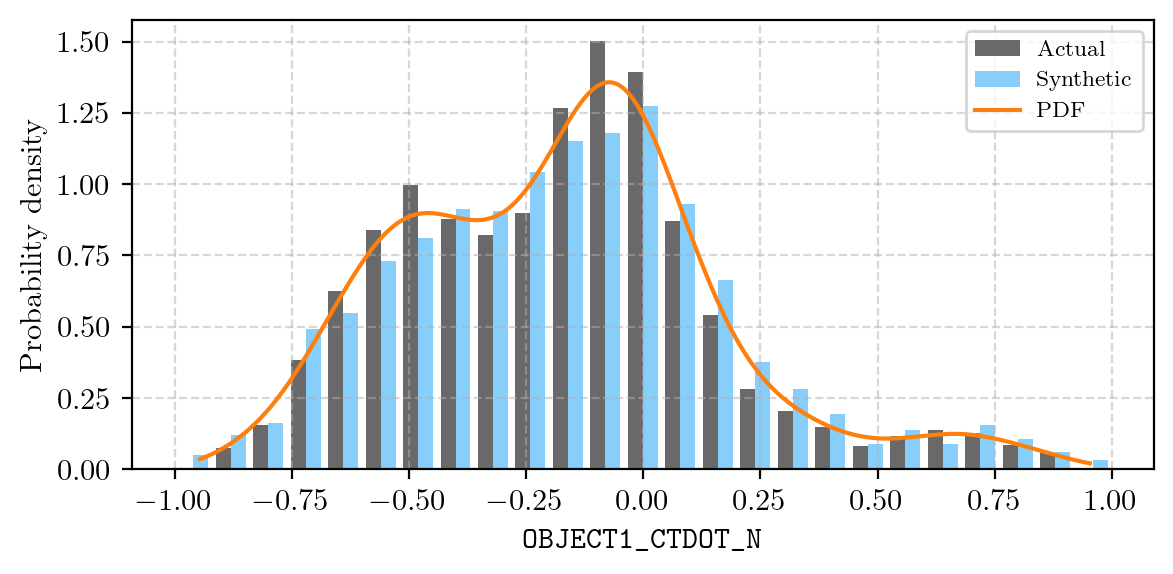

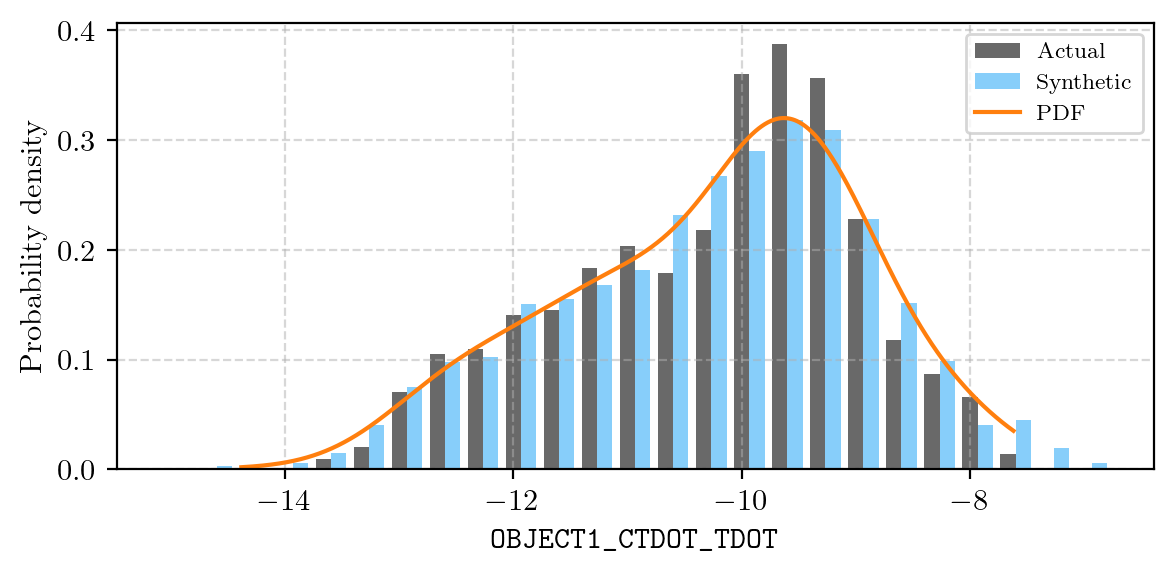

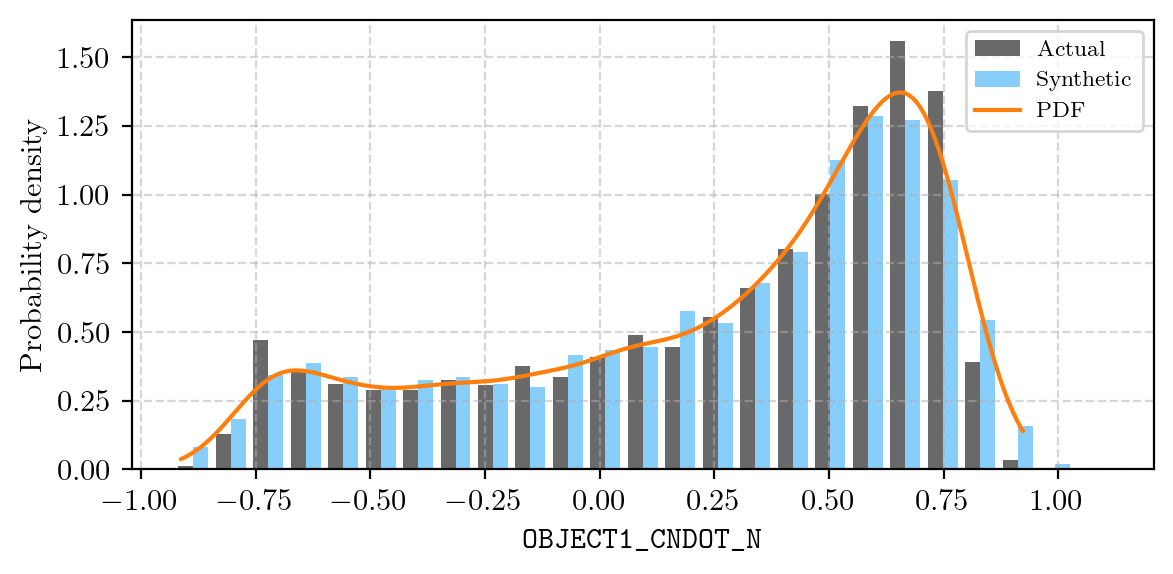

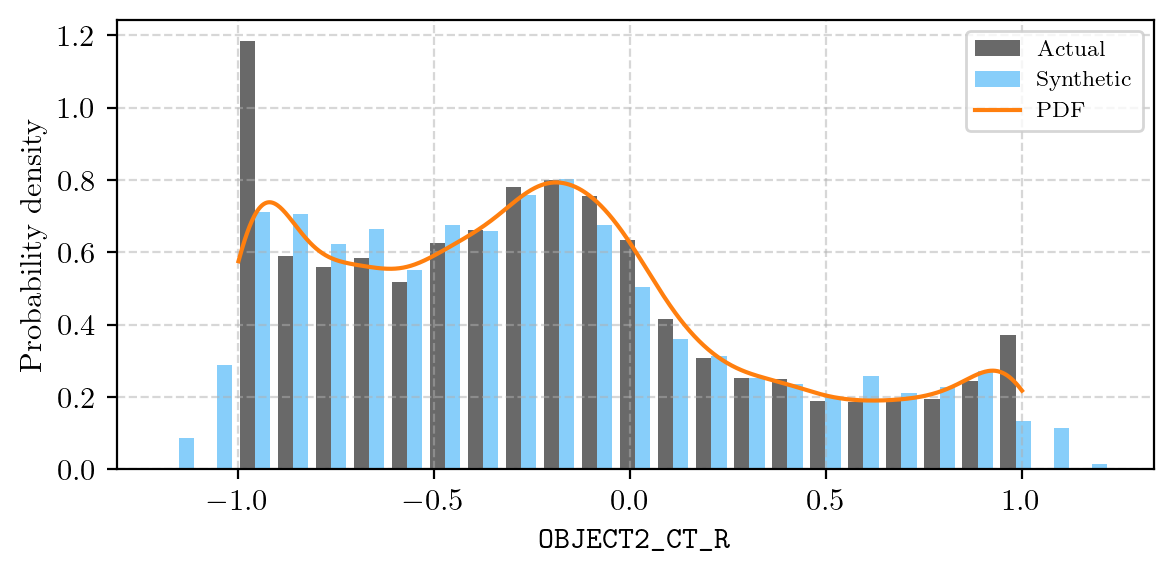

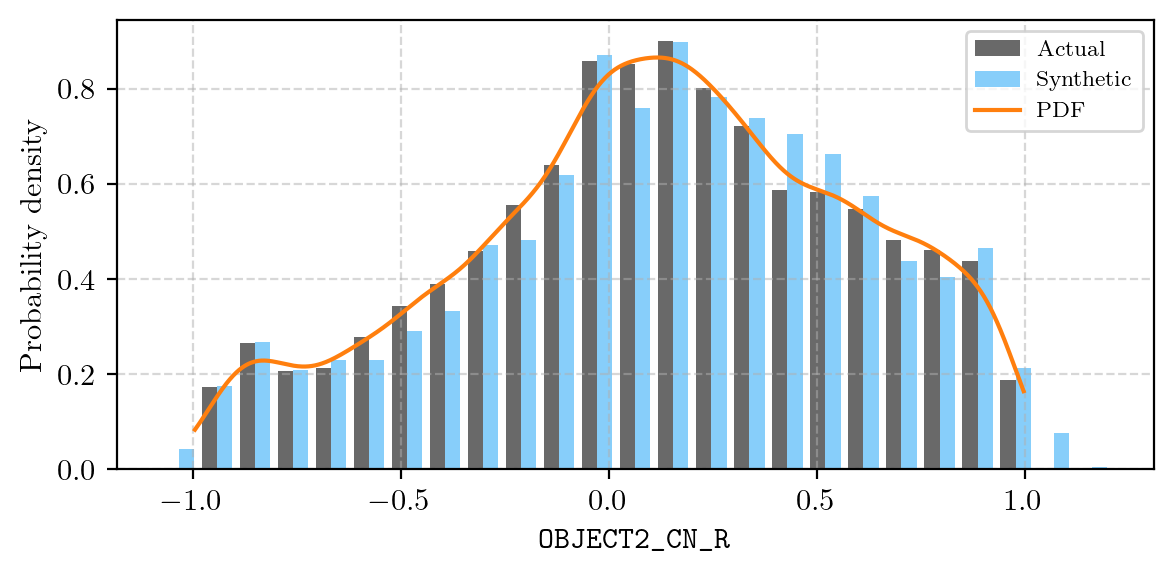

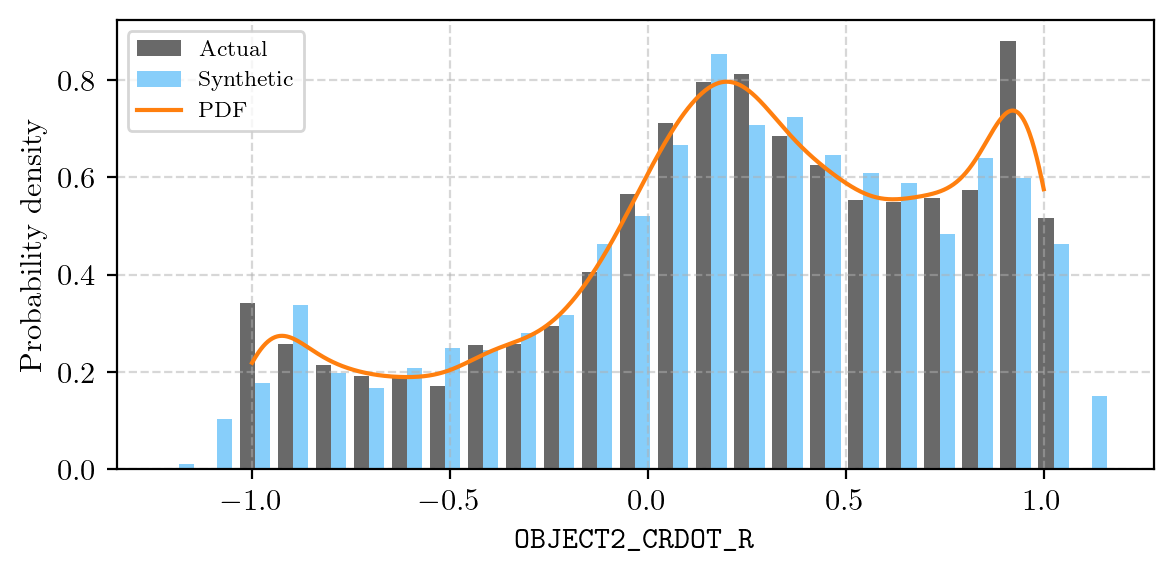

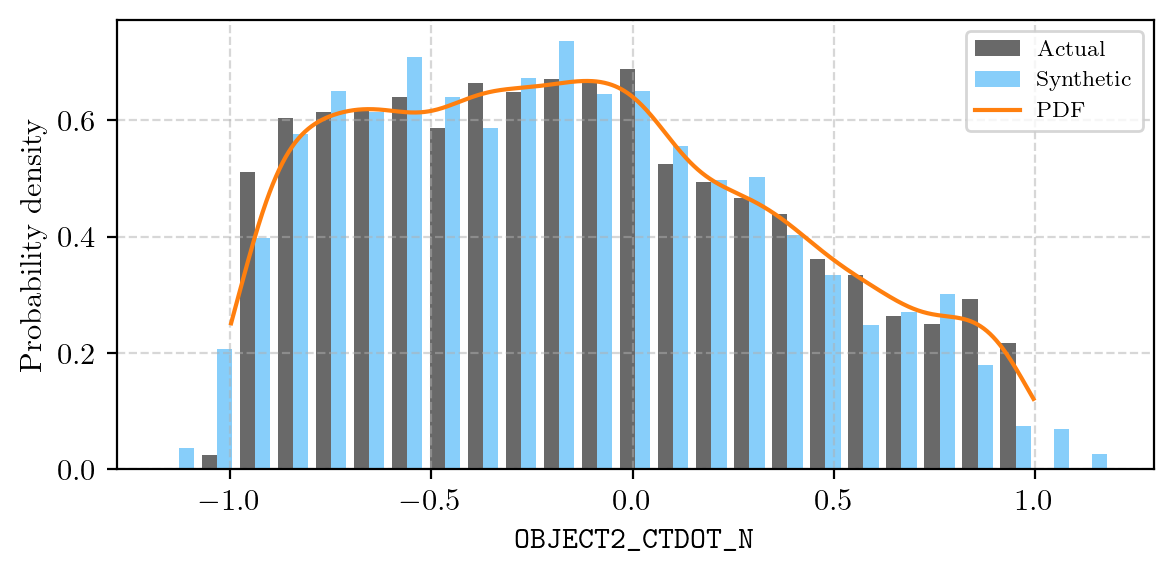

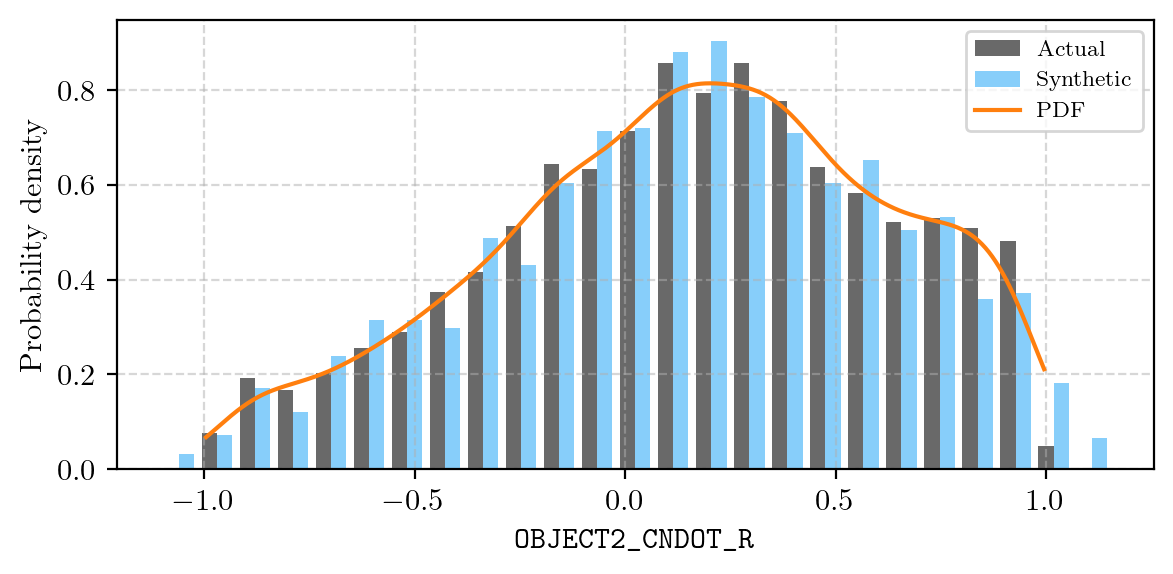

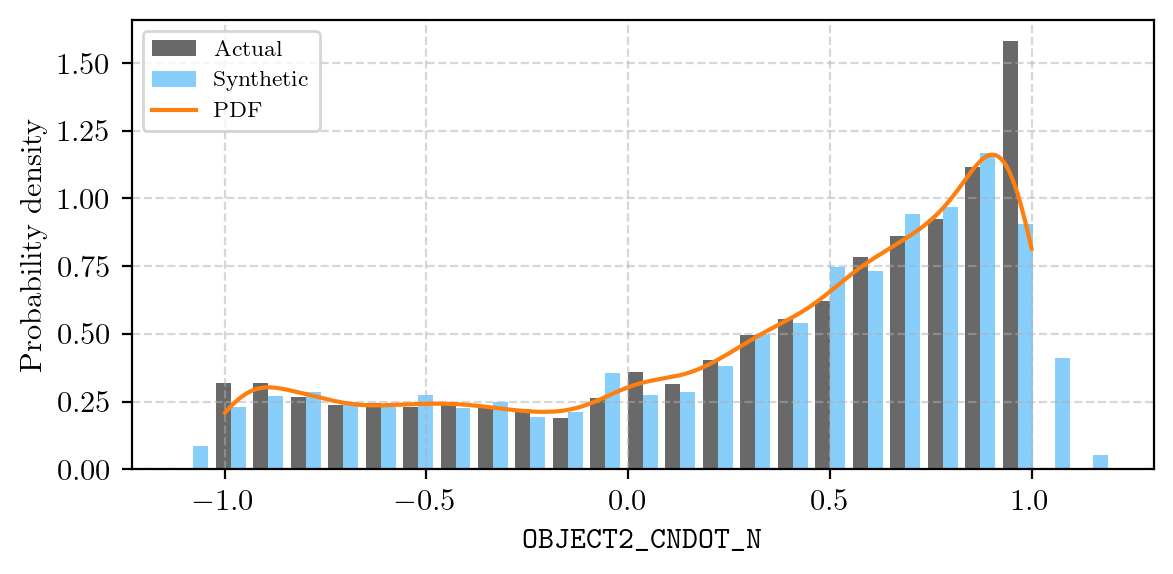

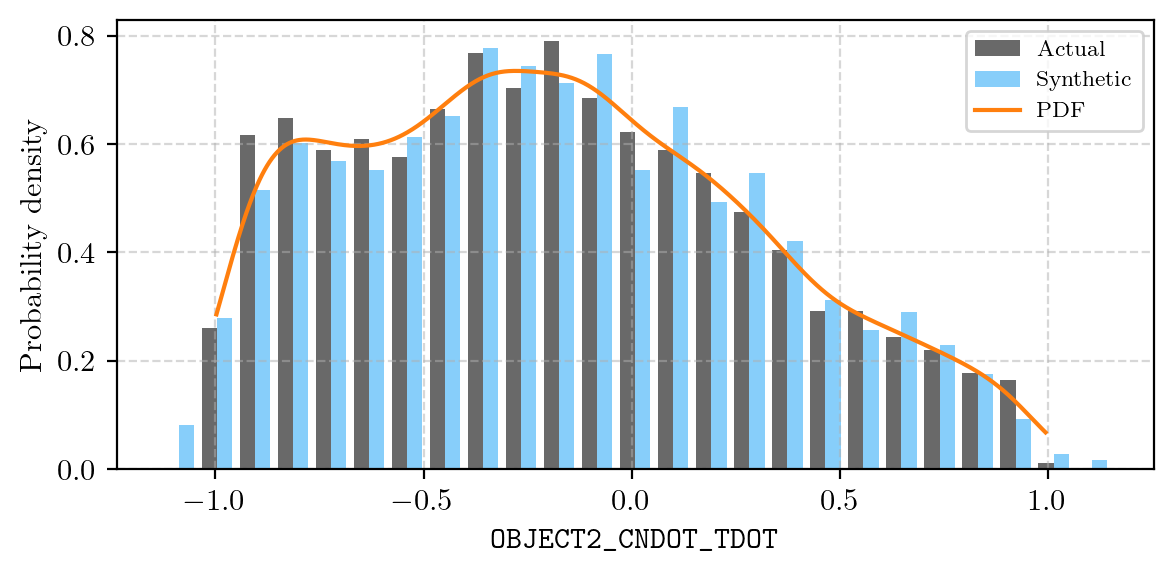

In [11]:
import scalib.sdg as sdg
reload(sdg)

for o in [1, 2]:
    for feature in obligatory_features['data_covariance_obligatory']:
        feature = f'OBJECT{o}_{feature}'

        filepath = os.path.join(utils.cwd,'sdg',f'SDG-{feature}.pkl')
        plotpath = os.path.join(utils.cwd,'notebooks', 'images', 
                                'sdg', f'SDG-{feature}.pkl')

        # Set column name to study and remove outliers. 
        data = df[feature].dropna().to_numpy()

        # Get synthetic object
        synthetic = sdg.SyntheticDataGenerator(data = data, filepath=filepath)
        
        if feature in ['OBJECT2_CNDOT_N', 'OBJECT2_CNDOT_TDOT']:
            synthetic.underfitting_factor += 1

        if synthetic.dist_r2_score<synthetic.r2_threshold:
            synthetic.plot_histogram(xlabel=r'\texttt{' + feature + '}')

# print(synthetic)


### 3.1. - Ballistic and Solar Radiation coefficients normalization using `RobustScalerClipper()` class

In [ ]:
# Apply RobustScalerClipper normalization to ballistic and solar radiation's 
# coefficients.
features = cfg.get_features(**{'cluster':'coefficients'})

for feature in features:

    # Initialize normalizer for the feature
    normalizer = eda.RobustScalerClipper(df[feature], quantiles=(0.01,0.99))

    scale        = normalizer.scale
    outliers     = normalizer.clip().outliers
    dft[feature] = normalizer.clip().clipped_data

    # Plot Target and Chaser histograms
    figname = 'coefficients-' + feature + '.pdf'
    filepath = os.path.join(cwd,'notebooks','images','normalized', figname)
    kwargs = {'title': f'Histogram\n \small ' + \
                       f'(Based on the last CDM data of every event) \n' + \
                       f' \small Scaling factor = {normalizer.scale}' + \
                       f' ({outliers/len(normalizer.data)*100:.2f}\% clipped)',
              'xlabel': r'\texttt{' + feature + '}',
              'bins': 80, 
              'xlim':(-1.0, 1.0),
              'legend': False, 
              'describe_colnames':[r'Feature'], 'filepath':filepath}

    dft_plot = dft.drop_duplicates('event_id', keep='last')

    eda.plot_histogram(dft_plot, [feature], **kwargs)

In [ ]:
# Analyse the conjunction's data distributions
features = cfg.get_features(**{'cluster':'orb_elements'})

for feature in features:

    if feature[2:]=='j2k_ecc': continue

    df.loc[df[feature]<=0, feature] = np.nan
    normalizer = eda.RobustScalerClipper(df[feature], 
                                         quantiles=(0.01,0.99), 
                                         with_offset=True)

    scale    = normalizer.scale
    offset   = normalizer.offset
    outliers = normalizer.clip().outliers

    dft[feature] = normalizer.scaled_data

    # Plot Target and Chaser histograms
    figname = 'orb_elements-' + feature + '.pdf'
    filepath = os.path.join(cwd,'notebooks','images','normalized', figname)
    
    kwargs = {'title': f'Histogram\n \small ' + \
                       f'(Based on the last CDM data of every event) \n' + \
                       f'\small Scaling factor = {scale} - ' + \
                       f'Offset = {-offset if offset!=None else 0:.3f}',
              'bins':80,
              'xlabel': r'\texttt{' + feature + '}', 
              'xlim':(0.0, utils.round_by_om(np.max(dft[feature]))), 
              'legend':False,
              'describe_colnames':[r'Feature'], 
              'filepath':filepath}

    dft_plot = dft.drop_duplicates('event_id', keep='last')

    eda.plot_histogram(dft_plot, [feature], **kwargs)

### 3.2. - State vector covariance matrix: main diagonal normalization using `log` scaling and `clipping`

The normalization for the main diagonal of the covariance matrix is performed using the following steps:

1. Apply natural $\log$ to the initial values.
2. Clip log values between -16.0 and 16.0.
3. Normalize values to be between -1.0 and 1.0 by using the width of the clipping range (-16.0, 16.0).

In [ ]:
# Apply data normalization and standardization to the main diagonal of the 
# covariance matrix.
xfeatures = cfg.get_features(**{'cluster':'covariance'})
for xfeature in [f[2:] for f in xfeatures if f.find('sigma')>=0]:

    # Get features names for both objects
    features = [o + xfeature for o in ['t_', 'c_']]

    # Normalize values using log.
    data = df[features].dropna().to_numpy().flatten()
    dft[features] = np.log(df[features])

    # Set clipping limits.
    clims = (-16.0, 16.0)

    # Clip values between -16.0 and 16.0
    outliers = np.sum(dft[features].values > clims[1]) + \
               np.sum(dft[features].values < clims[0])
    for feature in features:
        dft[feature] = np.clip(dft[feature], 
                               a_min = clims[0], 
                               a_max = clims[1])/((clims[1]-clims[0])/2.0)

    # Plot Target and Chaser histograms
    figname = 'covariance-' + xfeature + '.pdf'
    filepath = os.path.join(cwd,'notebooks','images','normalized', figname)

    kwargs = {'title': f'Histogram \n\small ' + \
                       f'Outliers clipped: {outliers} ' + \
                       f'({outliers/len(data)*100:.2f}\%)',
              'hist_kwargs':[dict(label=r'Target', color='tab:blue', alpha=0.6), 
                    dict(label=r'Chaser', color='tab:orange', alpha=0.6)],
              'xlim': (-1.0,1.0), 
              'bins':80,
              'xlabel': r'$\log(\texttt{' + xfeature + r'})$', 
              'describe_colnames':[r'Target', r'Chaser'], 
              'filepath':filepath}

    eda.plot_histogram(dft, features, **kwargs)

### 3.3. - Miscellaneous data: determinant of the position vector covariance matrix and energy dissipation rate

In [ ]:
# Apply normalization and standardization to some miscellaneous data.

for xfeature in ['position_covariance_det', 'sedr']:

    # Get features names for both objects
    features = [o + xfeature for o in ['t_', 'c_']]

    # Create a deep copy of the columns from the original dataset.
    dft.loc[:,features] = df[features].copy(deep=True)

    # Set values from determinant lower or equal to 0 as nan.
    for feature in features: dft.loc[df[feature]<=0, feature] = np.nan
        
    # Normalize values using log.
    dft[features] = np.log(dft[features])

    # Clip values
    if xfeature == 'position_covariance_det':
        clims = (0.0, 60.0)
        xlim = (0.0,1.0)
    else:
        clims = (-15.0, 0.0)
        xlim = (-1.0, 0.0)

    outliers = np.sum(dft[features].values > clims[1]) + \
               np.sum(dft[features].values < clims[0])

    for feature in features:
        dft[feature] = np.clip(dft[feature], 
                               a_min = clims[0], 
                               a_max = clims[1])/(clims[1]-clims[0])

    # Plot Target and Chaser histograms
    figname = 'miscellaneous-' + xfeature + '.pdf'
    filepath = os.path.join(cwd,'notebooks','images','normalized', figname)

    kwargs = {'title': f'Histogram \n\small ' + \
                       f'Outliers clipped: {outliers} ' + \
                       f'({outliers/len(data)*100:.2f}\%)',
              'hist_kwargs': [dict(label=r'Target', color='tab:blue', alpha=0.6), 
                    dict(label=r'Chaser', color='tab:orange', alpha=0.6)],
              'xlim': xlim,
              'bins': 80,
              'xlabel': r'$\log(\texttt{' + xfeature + r'})$',
              'describe_colnames':[r'Target', r'Chaser'], 
              'filepath':filepath}

    eda.plot_histogram(dft, features, **kwargs)

## 4. - Transformed training data export

In [ ]:
# Sort values of dataframe by event_id and time_to_tca and re-index
dft.sort_values(by=['event_id', 'time_to_tca'], axis='index', 
               ascending=[True,False], inplace=True, ignore_index=True)

# Save transformed training dataset
dft.to_csv(path_or_buf=os.path.join(cwd,'data','esa-challenge',
                                    'train_data_transformed.csv'), 
           sep=',', header=True, index=False, decimal='.')

# Show first data points to explore data types
display(dft.head(10))

## 5. -  Feature engineering towards Neural Networks processing

### 5.1. - Features segregation

As a first step towards the development of the deep learning model it is required to segregate the features using the following criteria:
 
 - **Output**: Target features that to be predicted by the neural network.
 - **Input**: Features that will feed the neural network. In turn, depending on how they behave throughout the conjunction event, these features shall be segregated into two groups:
    - **Constant**: Features whose values are fixed or roughly constant throughout the entire conjunction event (i.e. chaser object type, or orbital element features). These features do not need Time-Series forecasting processing. 
    - **Variable**: Features whose values change for every Conjunction Data Message received from a specific conjunction event (i.e. miss distance, relative position features). These features need to be forecasted into the feature.

Additionally, both constant and variable from input features groups can be either categorical or continuous. This segregation is also required for embedding processing in the deep learning model.

In [ ]:
# Get list of event_ids
event_ids = dft['event_id'].cat.categories.values

# Initialize output features
out_features = ["risk", "max_risk_estimate"]

# Get input features
in_features = [f for f in dft.columns if not f in out_features and \
               not f in ['event_id', 'mission_id', 'max_risk_scaling']]


# Separate continuous features from categorial features for embedding processing 
# of the later.
cat_features = [f for f in in_features if dft[f].dtype=='category']
cont_features = [f for f in in_features if not f in cat_features]


### 5.2. - Feature variability analysis per event

In order to segregate fixed or roughly constant features in the event, an analysis of the variability per event shall be performed for every feature. A feature is considered to be constant if (1) the standard deviation for all the values in a given event is 0 or 2 orders of magnitude smaller than the mean and (2) criteria (1) happens in more than 90% of all events.

In [ ]:
# Compute standard deviation, and mean of every feature per event_id.
events_std    = dft[['event_id'] + cont_features].groupby(['event_id']).std()
events_mean   = dft[['event_id'] + cont_features].groupby(['event_id']).mean()

# Evaluate variability of feature per event_id using the order of magnitude
events_var = pd.DataFrame(index=event_ids, columns=cont_features)

for feature in cont_features: 
    events_var[feature] = (events_mean[feature]/events_std[feature]) \
                          .apply(lambda x: utils.om(x))

# Initialize and print criteria used to class features as globally constant or 
# variable
om_criteria = 2
p_criteria = 0.1

print(f'Criteria for which a feature is considered CONSTANT:\n'
      f' (1.) - Locally (for a given event): if its mean is {om_criteria} '
      f'orders of magnitude bigger than its standard deviation, or its '
      f'standard deviation is 0.\n'
      f' (2.) - Globally (for the entire dataset): if criteria (1.) is met in '
      f'more than {p_criteria*100:2.0f}% of the total number of events.\n')

# Get array of continuous features that are constant and variables
var_features  = [f for f in cont_features if np.sum(events_var[f]<om_criteria)/len(events_var)>p_criteria]
cons_features = [f for f in cont_features if f not in var_features]

# Print results of analysis
print(f'Constant features: {len(cons_features)}')
results = [f'({np.sum(events_var[f]>=om_criteria)/len(events_var)*100:4.1f}%) {f}' for f in cons_features]
print(utils.tabular_list(results, n_cols = 4, col_sep=' - ', max_len=30))

print(f'\nVariable features: {len(var_features)}')
results = [f'({np.sum(events_var[f]<om_criteria)/len(events_var)*100:4.1f}%) {f}' for f in var_features]
print(utils.tabular_list(results, n_cols = 4, col_sep=' - ', max_len=30))

### 5.3. - Multiconilearity analysis using the *Variance Inflation Factor* (VIF)

Once the different clusters of CDM features have been seggregated and identified, it is important to analyse the multicollinearity that underlies the dataset as it can raise the variance of coefficient estimates, leading to larger confidence intervals (greater uncertainty). To summarise, even though multicollinearity may not interfere with model performance, it does negatively impact the interpretation of the predictors used to build the model.

In order to detect all features in the dataset that are multicollinear, the Variance Inflation Factor is used. The Variance Inflation Factor (VIF) directly measures the ratio of the variance of the entire model to the variance of a model with only the feature in question. The mathematical expression is the following:

$$VIF = \frac{1}{1-R^{2}}$$

where $R^{2}$ is the coefficient of determination, a measure of the variation in the dependent variable that is predictable from the independent variable(s). A VIF of $1$ ($R^{2}=0$) indicates that the feature has no correlation with any of the other features. Typically, any feature with a VIF value exceeding $5$ ($R^{2} \geq 0.8$) is considered to be too high; that is, it is very likely contributing to multicollinearity.

In the code-block below two functions are developed to compute VIF and to use this factor to remove features with multicollinearity according to a given threshold.

#### 5.3.1. - Constant features

In [ ]:
# Set maximum variance inflation factor identify collinear features
maxvif = 5

# Get only the last CDM from every event for faster multicollinearity analysis.
dft_lastCDM = dft[['event_id'] + cons_features].drop_duplicates('event_id', keep='last')

# Analyse multicollinearity between constant features
collinearity = utils.vif_selection(dft_lastCDM, maxvif = maxvif)

print(f'Multicollinearity analysis for CONSTANT features.\n\n'
      f'Criteria -> Feature is independent if R2 < {1-1/maxvif:4.2f}, correlated otherwise')

for c in ['correlated', 'independent']:
    col_features = list(collinearity[c].keys())
    col_features.sort()
    print(f'\n{c.capitalize()} features: {len(col_features)} ')
    print(utils.tabular_list(col_features, n_cols = 2, col_sep=' - ', max_len=30))

ind_cons_features = list(collinearity['independent'].keys())

#### 5.3.2. - Variable features

In [ ]:
# Set maximum variance inflation factor identify collinear features
maxvif = 5

# Get only the last CDM from every event for faster multicollinearity analysis.
dft_lastCDM = dft[['event_id'] + var_features].drop_duplicates('event_id', keep='last')

# Analyse multicollinearity between constant features
collinearity = utils.vif_selection(dft_lastCDM, maxvif = maxvif)

print(f'Multicollinearity analysis for VARIABLE features.\n\n'
      f'Criteria -> Feature is considered to be independent if R2 < {1-1/maxvif:4.2f}, correlated otherwise')

for c in ['correlated', 'independent']:
    col_features = list(collinearity[c].keys())
    col_features.sort()
    print(f'\n{c.capitalize()} features: {len(col_features)} ')
    print(utils.tabular_list(col_features, n_cols = 4, col_sep=' - ', max_len=30))

ind_var_features = list(collinearity['independent'].keys())